<a href="https://colab.research.google.com/github/mgarzon/w24-honours-LateralMovement/blob/main/CSI4900_JihadJarade_DaliaSawaya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Anomaly-based Detection of Lateral Movement in a Microsoft Windows Environment**

By: Jihad Jarade (300185815) and Dalia Sawaya (300111681)\
Supervised by: Dr. Miguel Garzon\
Course: CSI4900 - Dr. Wonsook Lee

#**Introduction**

The goal of our honours project is to develop an anomaly detection model tailored for identifying anomalous behaviours within Windows-based environments. Specifically, we aim to leverage Windows System logs and machine learning algorithms to detect suspicious lateral movement techniques used by potential threats. To achieve this, we will gather training and test data, conduct profiling to gain insight on the data, create features to help target specific attacks, design our machine learning model and finally, implement the model and analyse results.

Windows event logs are records of events that have occurred on a computer running the Windows operating system. These records contain information regarding actions that have taken place on the installed applications, the computer, and the system itself. It’s by analysing these logs that we will try to identify lateral movement. Lateral movement is the process by which attackers spread from an entry point to the rest of the network. In simpler terms, it is when an attacker successfully hacks one machine on a network and then tries to move from this machine to the others it is connected to. To identify lateral movement in Windows logs, we’ll be training a machine learning model.

Machine learning enables computers to learn from data and make decisions or predictions without being explicitly programmed to do so. It’s a subset of Artifical Intelligence that incorporates math and statistics in order to learn from the data itself, and improve with experience. Anomaly detection is the machine learning technique we decided to use. Anomaly detection is the process of identifying data points, entities or events that fall outside the normal range. An anomaly is anything that deviates from what is standard or expected.

For anomaly detection we will implement a one-class model only trained on malicious data. The model would be tested on regular clean data and some malicious attacks. So, our model would call malicious data inliers, and clean data outliers. In practice, whenever the model finds an inlier, this means that it detected a malicious attack.

###Import Important Libraries

In [ ]:
import pandas as pd
import numpy as np
import requests
import warnings
import matplotlib.pyplot as plt
import json
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from zipfile import ZipFile
from io import BytesIO
from pandas.io import json
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

from datetime import timedelta

In [ ]:
# For use in google collab

# from google.colab import drive
# drive.mount('/content/drive')

#**Collection of the Training Dataset**

To develop an effective detection model for lateral movement attacks, we needed a good training dataset. Fortunately, we discovered a collection of Windows Logs documenting instances of such attacks compiled by reputable cybersecurity experts. As the data was in JSON format and separated by attack, we first converted each file into a dataframe and then combined them into one. We then saved this dataframe as a CSV for later use. They all came from the same source so the formats and data types matched well.

Source: https://securitydatasets.com/notebooks/atomic/windows/lateral_movement/intro.html



In [ ]:
# List of URLs containing training datasets for lateral movement attacks
training_datasets = ["https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/empire_smbexec_dcerpc_smb_svcctl.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/empire_psexec_dcerpc_tcp_svcctl.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/empire_dcom_shellwindows_stager.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/empire_psremoting_stager.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/empire_msbuild_dcerpc_wmi_smb.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/covenant_wmi_remote_event_subscription_ActiveScriptEventConsumers.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/covenant_sc_query_dcerpc_smb_svcctl.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/covenant_sharpsc_query_dcerpc_smb_svcctl.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/covenant_copy_smb_CreateRequest.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/covenant_sharpsc_create_dcerpc_smb_svcctl.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/covenant_sharpsc_start_dcerpc_smb_svcctl.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/covenant_sharpsc_stop_dcerpc_smb_svcctl.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/covenant_sharpwmi_create_dcerpc_wmi.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/covenant_psremoting_command.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/empire_wmic_add_user_backdoor.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/mimikatz_CVE-2020-1472_Unauthenticated_NetrServerAuthenticate2.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/covenant_dcom_executeexcel4macro_allowed.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/covenant_dcom_registerxll.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/empire_wmi_dcerpc_wmi_IWbemServices_ExecMethod.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/covenant_wmi_wbemcomn_dll_hijack.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/covenant_dcom_iertutil_dll_hijack.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/purplesharp_ad_playbook_I.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/schtask_create.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/schtask_modification.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/lateral_movement/host/aadinternals_export_adfsdatabaseconfig_remotely.zip",
        "https://raw.githubusercontent.com/OTRF/Security-Datasets/master/datasets/atomic/windows/credential_access/host/empire_over_pth_patch_lsass.zip"]


In [ ]:
# Function that merges the datasets given in an array from JSON format to a dataframe
def merge_datasets(dataset_array):
  merged_df = pd.DataFrame()
  for url in dataset_array:
    zipFileRequest = requests.get(url)
    zipFile = ZipFile(BytesIO(zipFileRequest.content))
    datasetJSONPath = zipFile.extract(zipFile.namelist()[0])
    new_df = json.read_json(path_or_buf=datasetJSONPath, lines=True)
    merged_df = pd.concat([merged_df, new_df])
  return merged_df

In [ ]:
# Merging the datasets into one dataframe
training_df = merge_datasets(training_datasets)

In [ ]:
# Used to convert dataframe into CSV
# training_df.to_csv('/content/drive/My Drive/training_df.csv', index=False)

#**Profiling**

We conducted a profiling analysis on the training data to get a better understanding of the dataset's structure, quality, and potential preprocessing needs before modeling. This also provided valuable information when selecting features for feature engineering. We assessed the size of our dataset, by seeing how many rows and columns it contained. We took a look at what data types we had and checked for null values. Finally, we plotted the range of values for each column in a graph.


### Dimensions

In [ ]:
# Display the number of rows and columns
print("Rows: " + str(len(training_df)))
num_columns = training_df.shape[1]
print("Columns: " + str(num_columns))

Rows: 194475
Columns: 322


### Identifying Features and Data Types

In [ ]:
# Display the number of columns per data type
print("Number of Columns per Data Type:")
column_types = training_df.dtypes
type_count = column_types.value_counts()
print(type_count)

Number of Columns per Data Type:
object     259
float64     61
int64        2
Name: count, dtype: int64


In [ ]:
# Display each feature and their data type
print("Data Types:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print(column_types)

Data Types:
Keywords                         object
SeverityValue                   float64
SourceImage                      object
EventID                           int64
ProviderGuid                     object
ExecutionProcessID              float64
Channel                          object
host                             object
AccountType                      object
UserID                           object
SourceProcessGUID                object
ThreadID                        float64
TargetImage                      object
GrantedAccess                    object
EventType                        object
Opcode                           object
EventTime                        object
EventReceivedTime                object
@timestamp                       object
SourceModuleType                 object
port                            float64
AccountName                      object
RecordNumber                    float64
SourceProcessId                  object
SourceThreadId              

###Identifying Null Values

In [ ]:
# Calculate the number of null values for each column
print("Checking for null values:")
null_counts = training_df.isnull().sum()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(null_counts)

Checking for null values:
Keywords                             0
SeverityValue                     3983
SourceImage                     151974
EventID                              0
ProviderGuid                      7257
ExecutionProcessID                3983
Channel                              0
host                              3983
AccountType                      44410
UserID                           44410
SourceProcessGUID               151979
ThreadID                          3983
TargetImage                     151974
GrantedAccess                   151979
EventType                        26754
Opcode                           16491
EventTime                         3983
EventReceivedTime                 3983
@timestamp                           0
SourceModuleType                  3983
port                              3983
AccountName                      44410
RecordNumber                      3983
SourceProcessId                 147887
SourceThreadId                  151979

In [ ]:
# Filter the null counts to display only columns with less than 100,000 empty values
print("Checking for null values under 100000:")
filtered_null_counts = null_counts[null_counts < 100000]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(filtered_null_counts)

Checking for null values under 100000:
Keywords                  0
SeverityValue          3983
EventID                   0
ProviderGuid           7257
ExecutionProcessID     3983
Channel                   0
host                   3983
AccountType           44410
UserID                44410
ThreadID               3983
EventType             26754
Opcode                16491
EventTime              3983
EventReceivedTime      3983
@timestamp                0
SourceModuleType       3983
port                   3983
AccountName           44410
RecordNumber           3983
Task                      0
Domain                44410
@version               3983
OpcodeValue           11237
SourceModuleName       3983
Severity               3983
SourceName                0
Version               11237
Category              16754
UtcTime               48935
Hostname                  0
RuleName              48933
tags                   3983
ProcessGuid           91440
Image                 91440
Message  

In [ ]:
# Display the first 5 non-null values for numeric columns in the training DataFrame
for dtype in column_types.unique():
    columns_of_type = column_types[column_types == dtype].index
    if dtype == 'float64' or dtype == 'int64':
        for column in columns_of_type:
            print(f"\nFirst 5 non-null Entries for column '{column}':")
            non_null_entries = training_df[column][training_df[column].notnull()]  #filtering non-null entries
            print(non_null_entries.head())  #printing the first 5 non-null entries


First 5 non-null Entries for column 'SeverityValue':
0    2.0
1    2.0
2    2.0
3    2.0
4    2.0
Name: SeverityValue, dtype: float64

First 5 non-null Entries for column 'ExecutionProcessID':
0    9848.0
1    8948.0
2    9848.0
3    9848.0
4    9848.0
Name: ExecutionProcessID, dtype: float64

First 5 non-null Entries for column 'ThreadID':
0    7976.0
1    9552.0
2    7976.0
3    7976.0
4    7976.0
Name: ThreadID, dtype: float64

First 5 non-null Entries for column 'port':
0    64545.0
1    64545.0
2    64545.0
3    64545.0
4    64545.0
Name: port, dtype: float64

First 5 non-null Entries for column 'RecordNumber':
0    1929240.0
1      37562.0
2    1929241.0
3    1929242.0
4    1929243.0
Name: RecordNumber, dtype: float64

First 5 non-null Entries for column 'SourceThreadId':
0    7488.0
2    7488.0
3    7488.0
5    7488.0
6    3588.0
Name: SourceThreadId, dtype: float64

First 5 non-null Entries for column '@version':
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: @version, dty

###Distribution of Numeric Columns


Distribution of values for column 'SeverityValue':


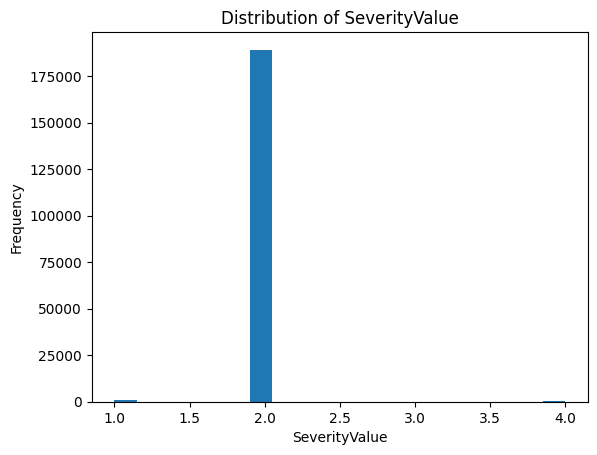


Distribution of values for column 'ExecutionProcessID':


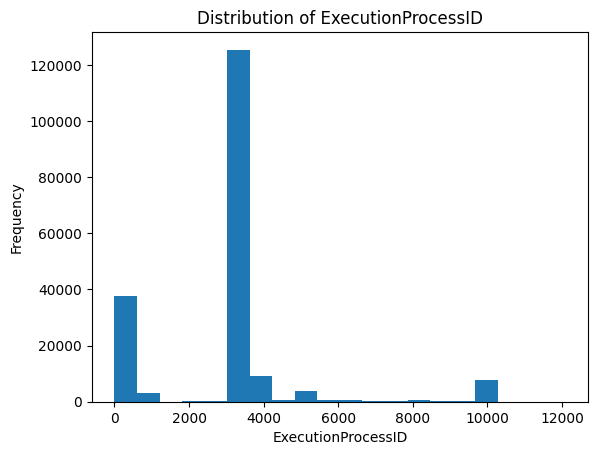


Distribution of values for column 'ThreadID':


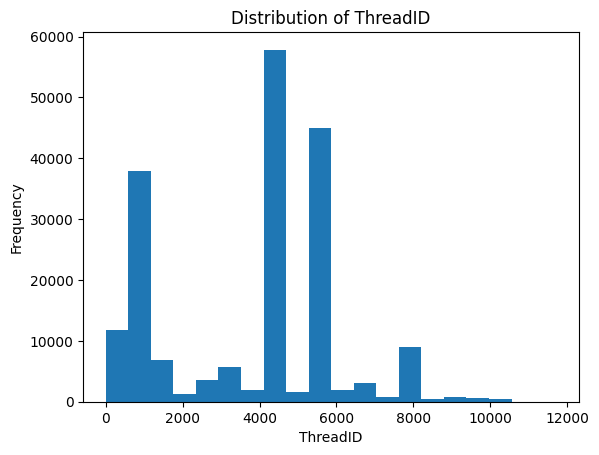


Distribution of values for column 'port':


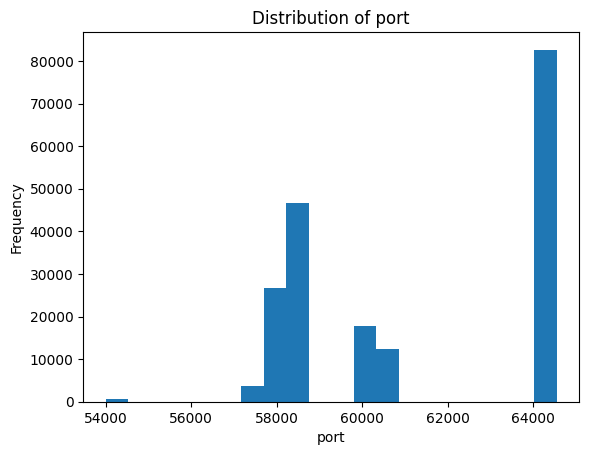


Distribution of values for column 'RecordNumber':


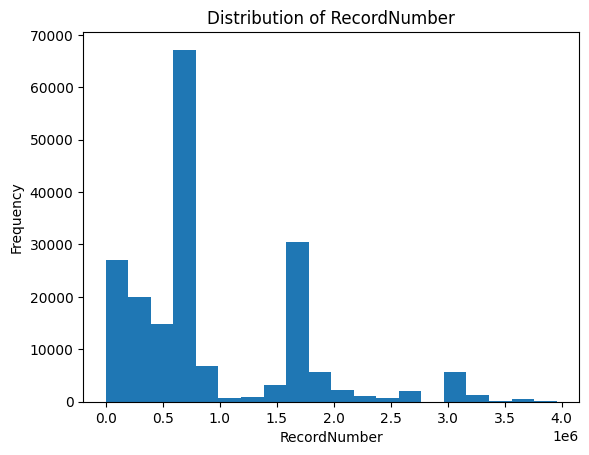


Distribution of values for column 'SourceThreadId':


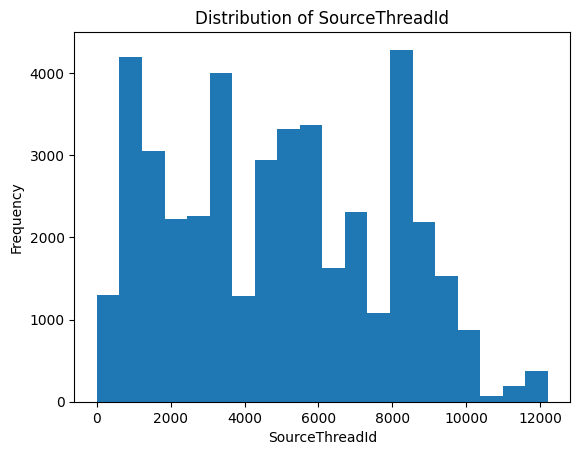


Distribution of values for column '@version':


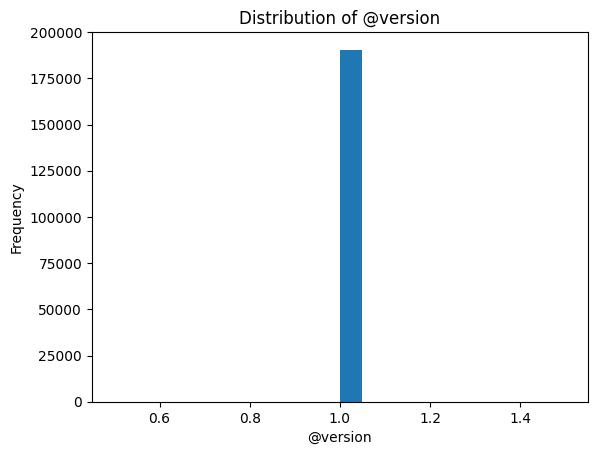


Distribution of values for column 'OpcodeValue':


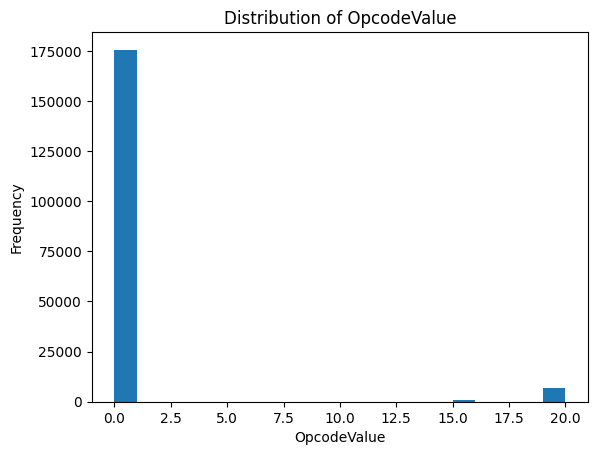


Distribution of values for column 'Version':


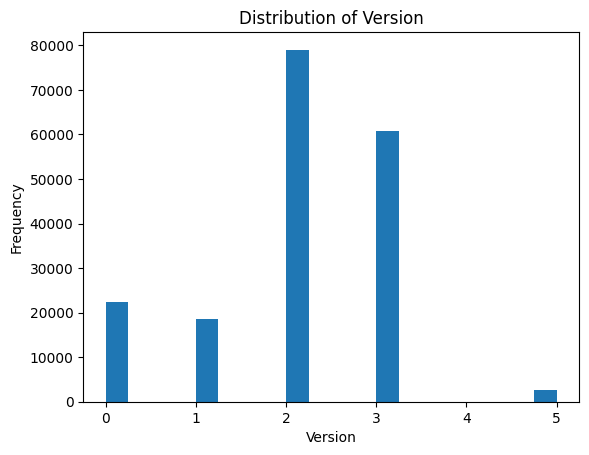


Distribution of values for column 'ERROR_EVT_UNRESOLVED':


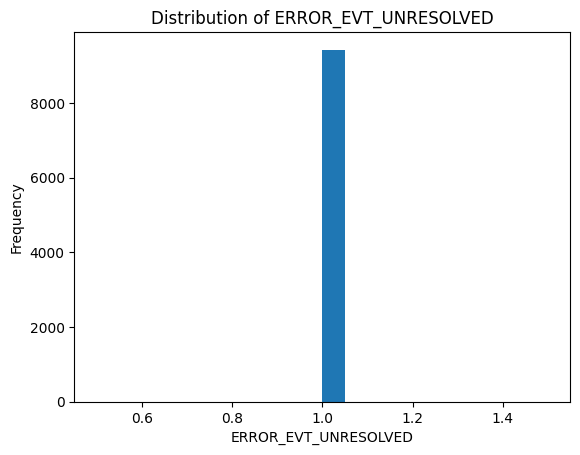


Distribution of values for column 'LogonType':


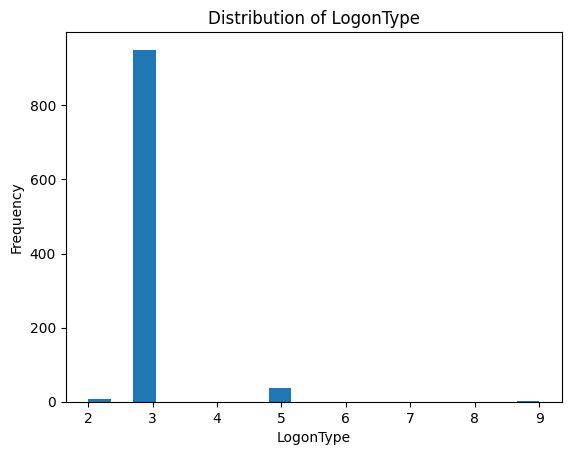


Distribution of values for column 'FilterRTID':


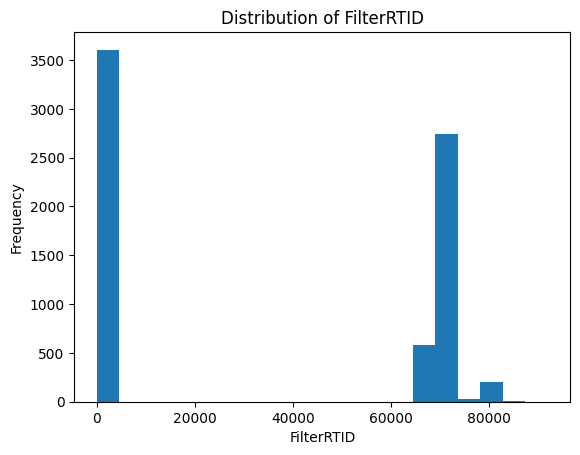


Distribution of values for column 'LayerRTID':


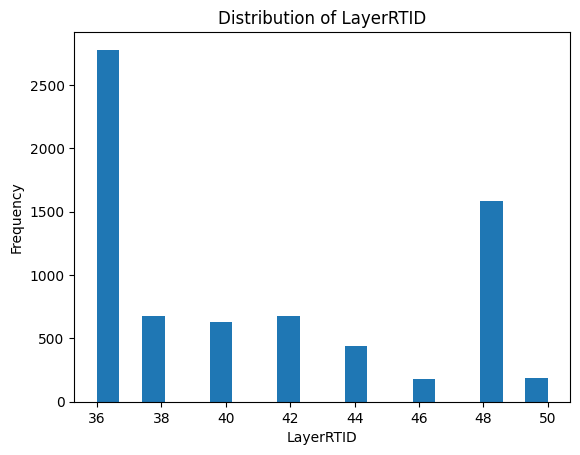


Distribution of values for column 'SourcePort':


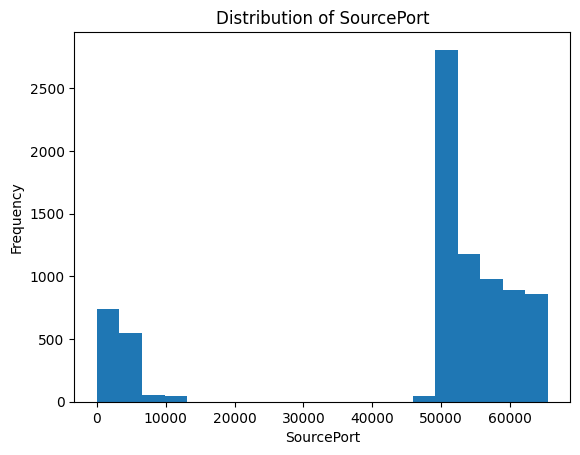


Distribution of values for column 'DestPort':


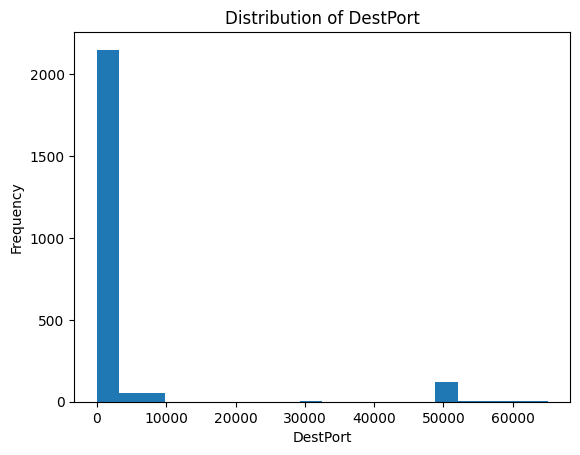


Distribution of values for column 'KeyLength':


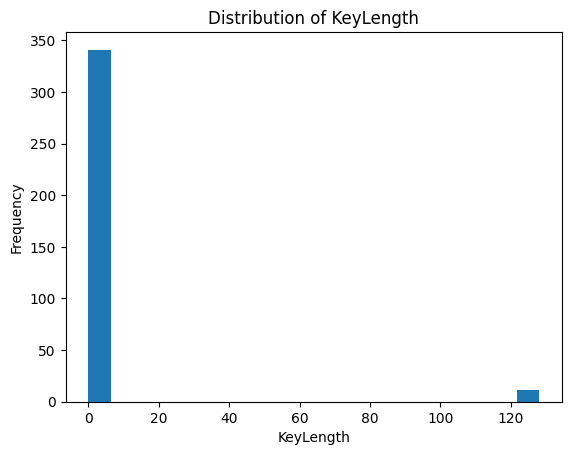


Distribution of values for column 'EventIdx':


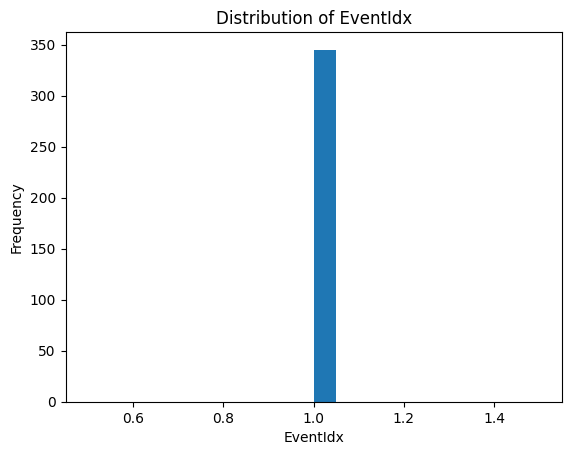


Distribution of values for column 'EventCountTotal':


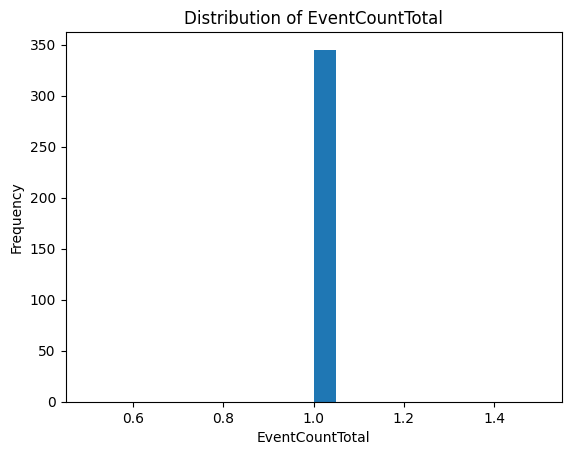


Distribution of values for column 'RestrictedSidCount':


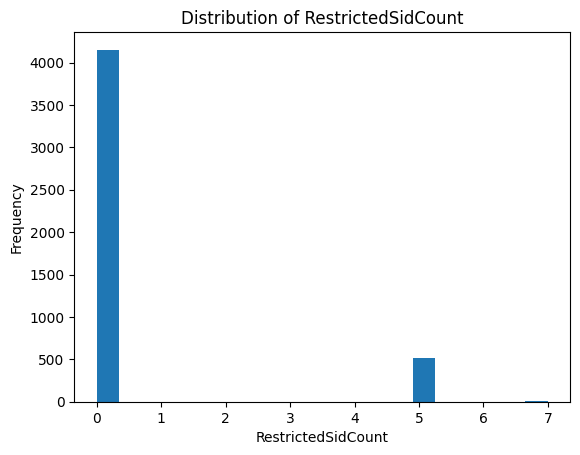


Distribution of values for column 'DestinationPort':


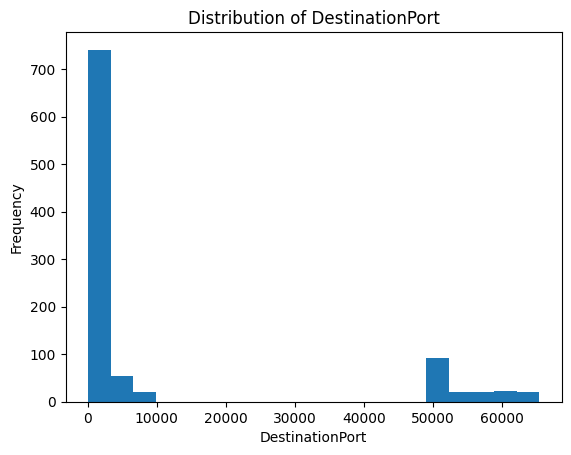


Distribution of values for column 'TerminalSessionId':


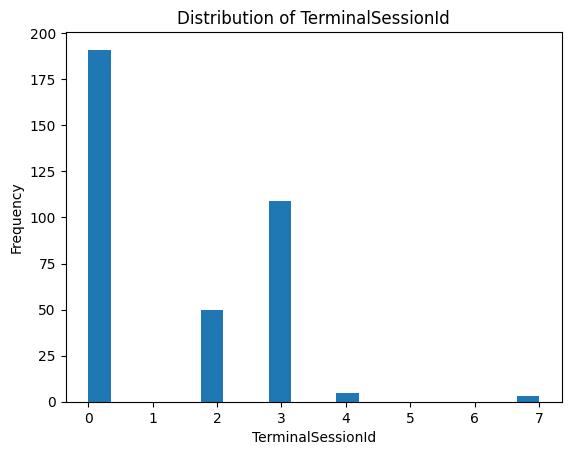


Distribution of values for column 'ParentProcessId':


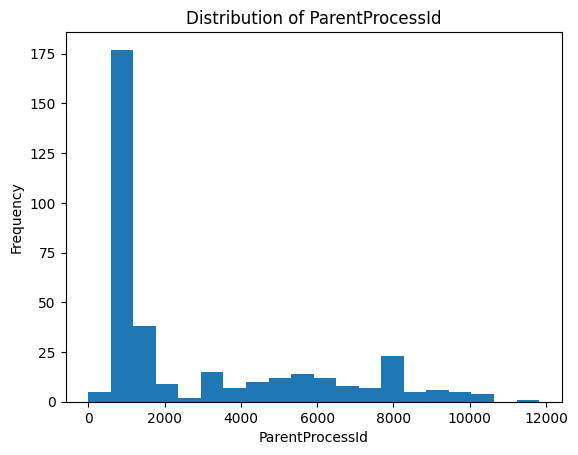


Distribution of values for column 'ServiceStartType':


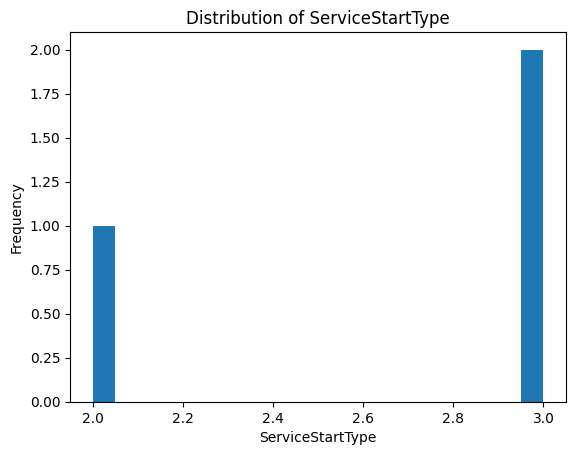


Distribution of values for column 'MessageNumber':


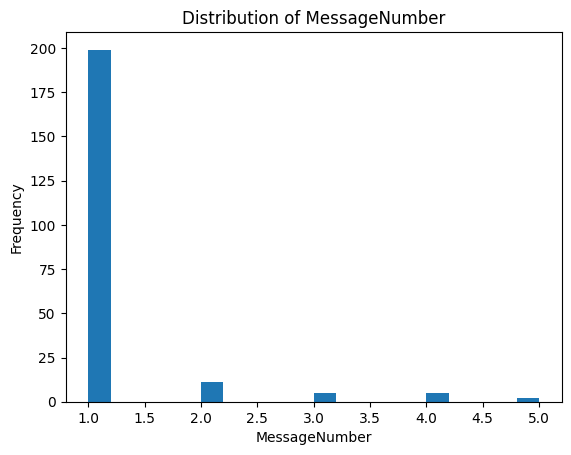


Distribution of values for column 'MessageTotal':


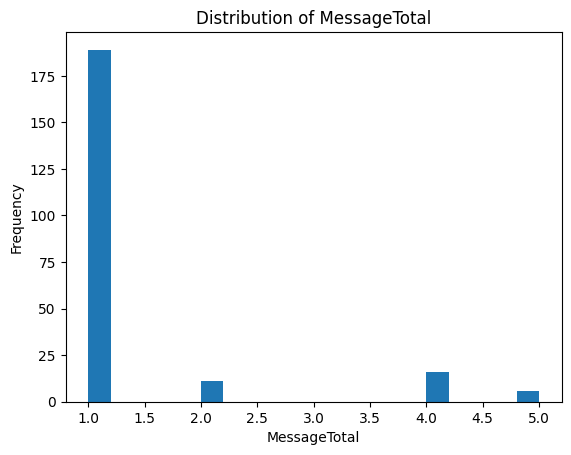


Distribution of values for column 'QueryStatus':


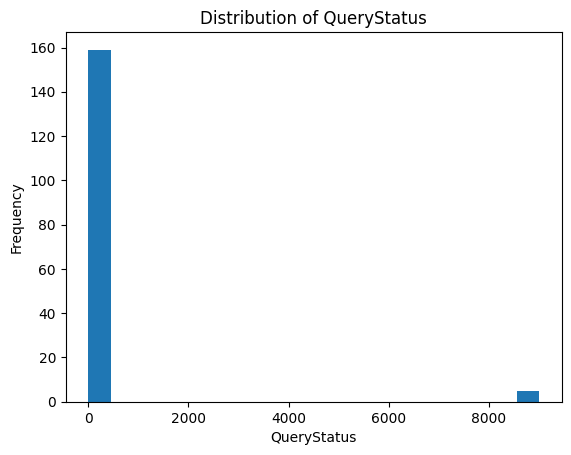


Distribution of values for column 'MiniportNameLen':


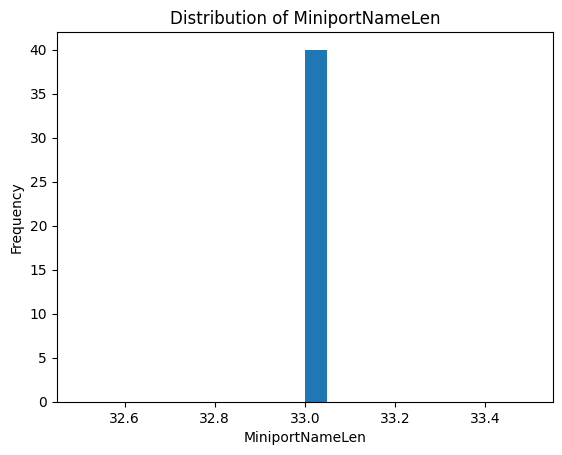


Distribution of values for column 'Priority':


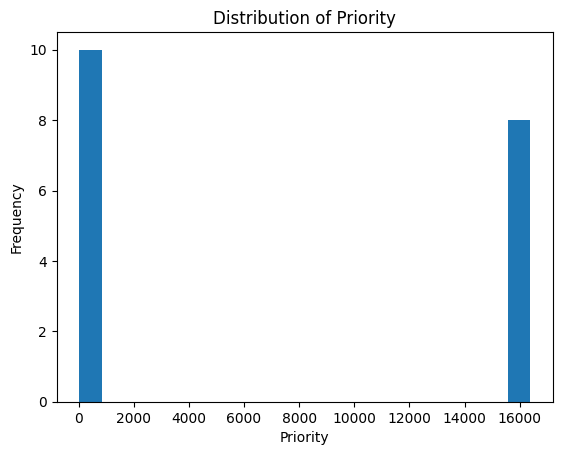


Distribution of values for column 'NewThreadId':


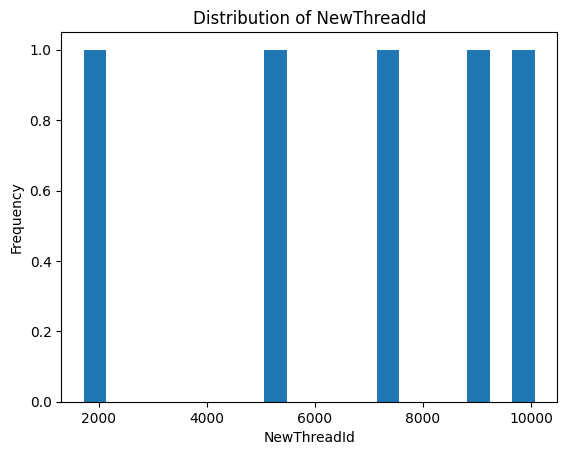


Distribution of values for column 'MinRunspaces':


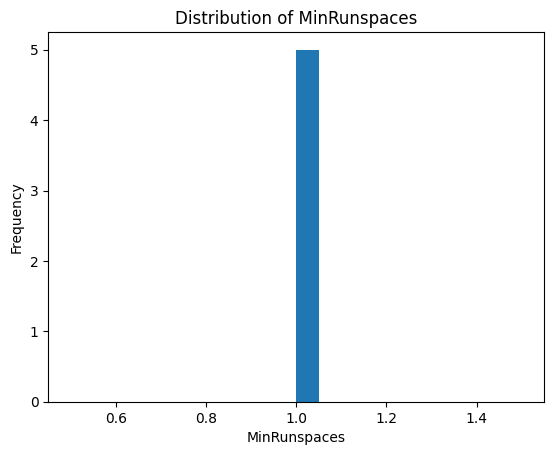


Distribution of values for column 'MaxRunspaces':


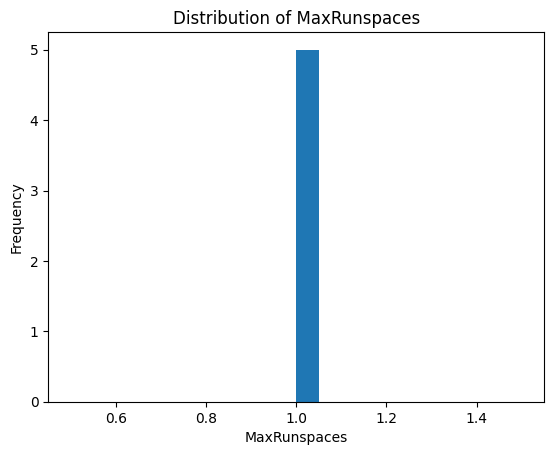


Distribution of values for column 'ClientProcessId':


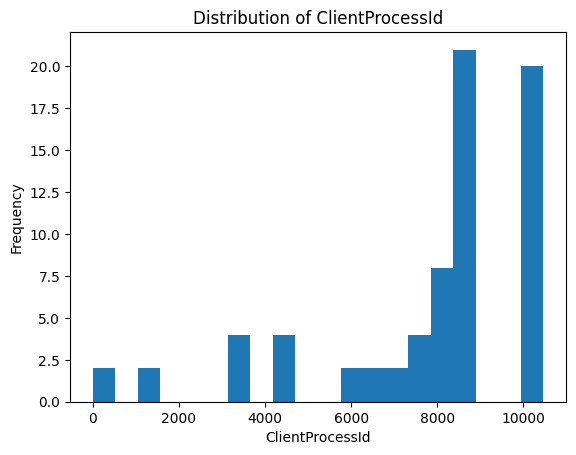


Distribution of values for column 'PreAuthType':


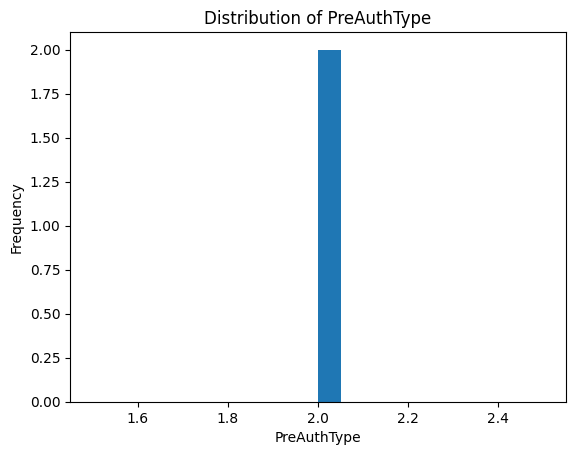


Distribution of values for column 'MinimumPasswordLengthAudit':


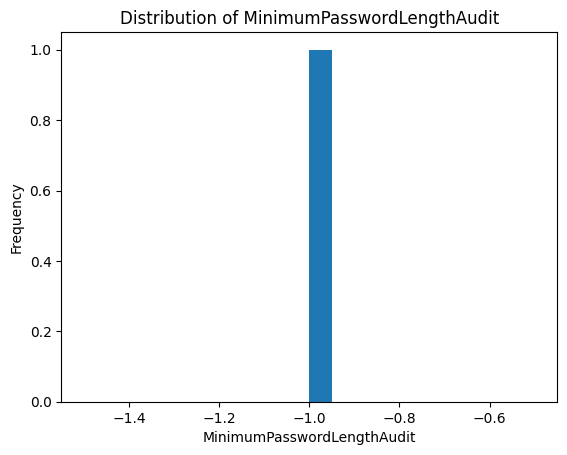


Distribution of values for column 'MinimumPasswordLength':


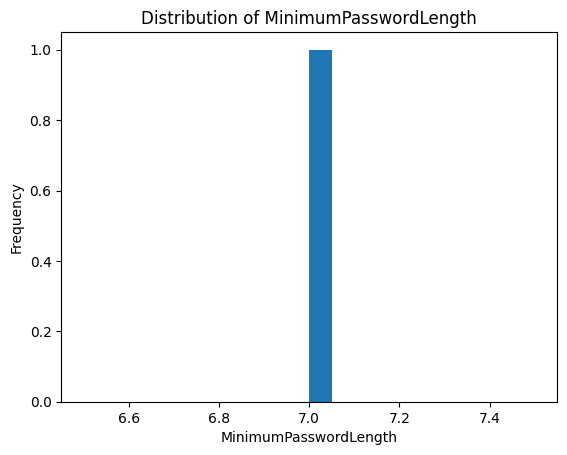


Distribution of values for column 'ProcessingMode':


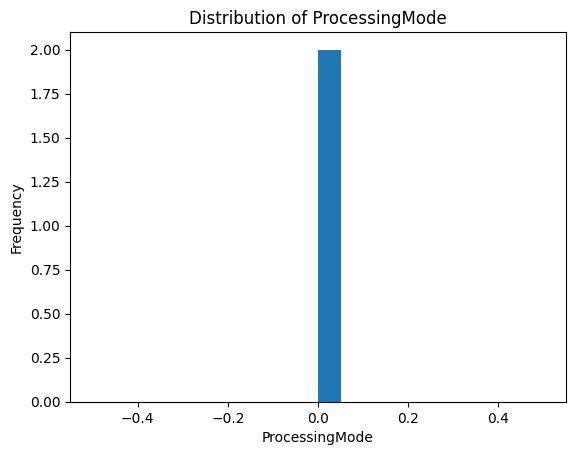


Distribution of values for column 'SupportInfo1':


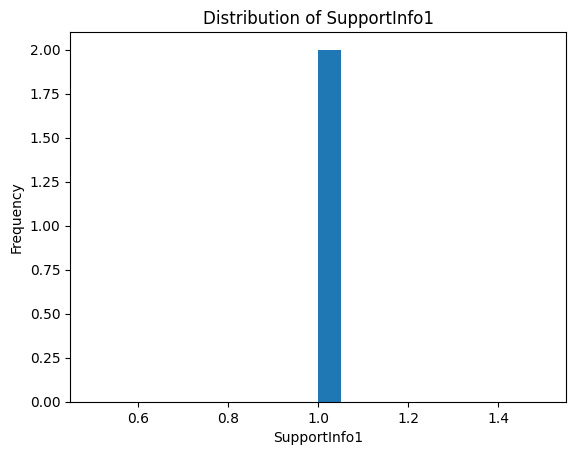


Distribution of values for column 'SupportInfo2':


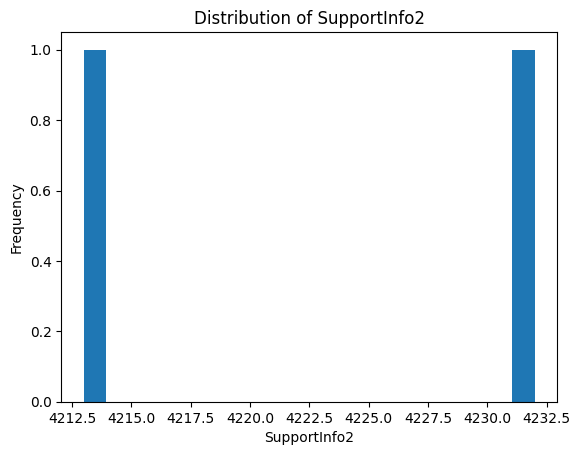


Distribution of values for column 'ProcessingTimeInMilliseconds':


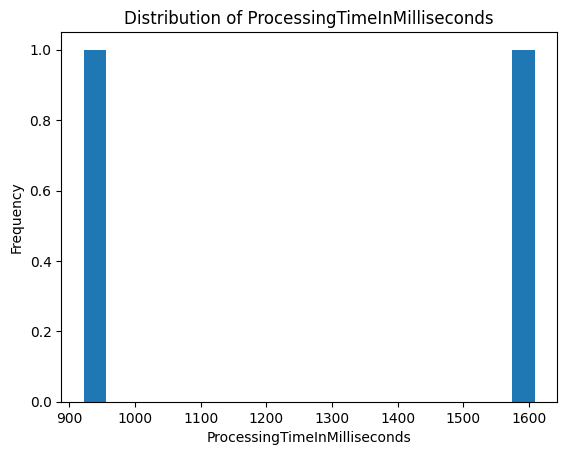


Distribution of values for column 'NumberOfGroupPolicyObjects':


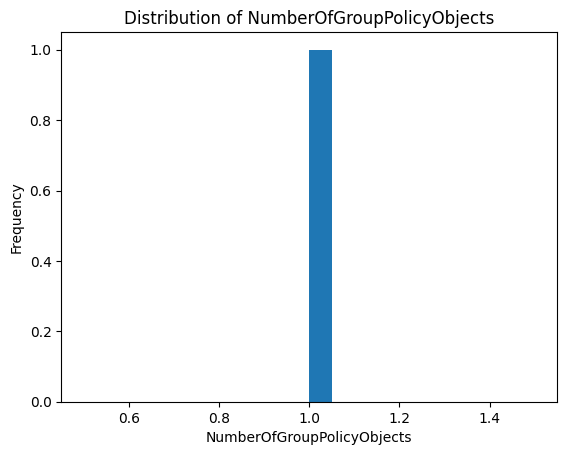


Distribution of values for column 'DomainBehaviorVersion':


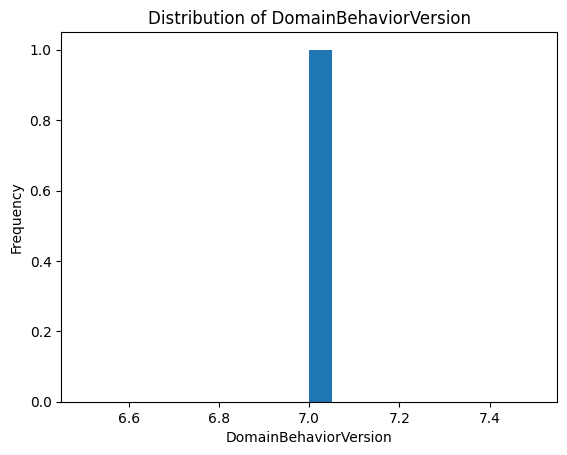


Distribution of values for column 'MixedDomainMode':


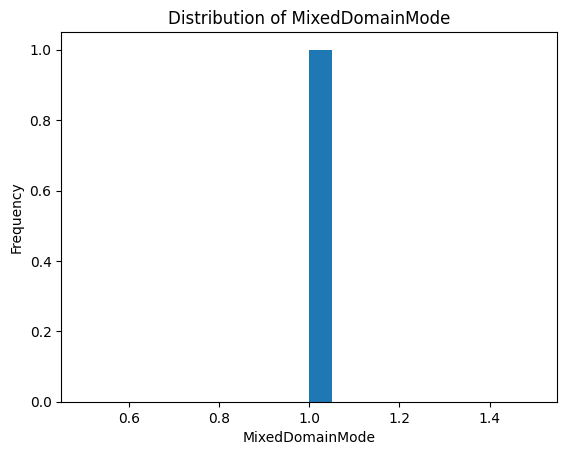


Distribution of values for column 'OemInformation':


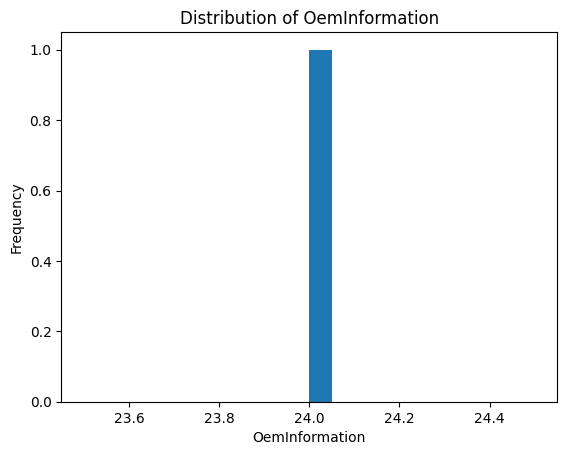


Distribution of values for column 'LayerId':


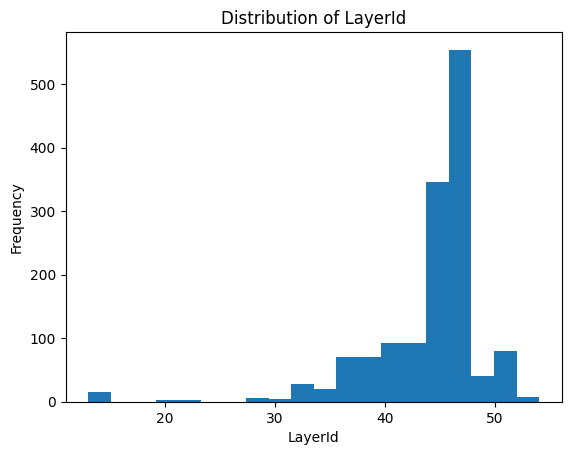


Distribution of values for column 'Weight':


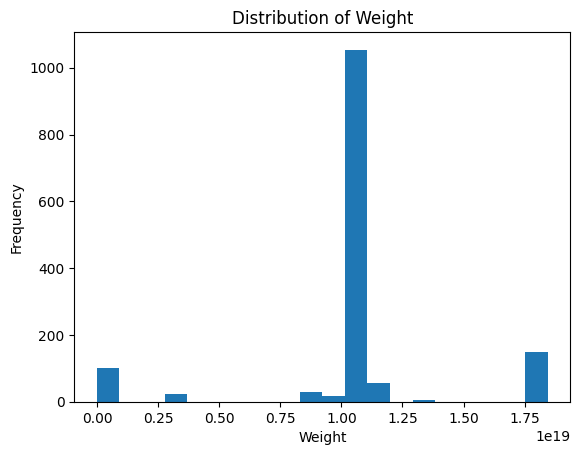


Distribution of values for column 'FilterId':


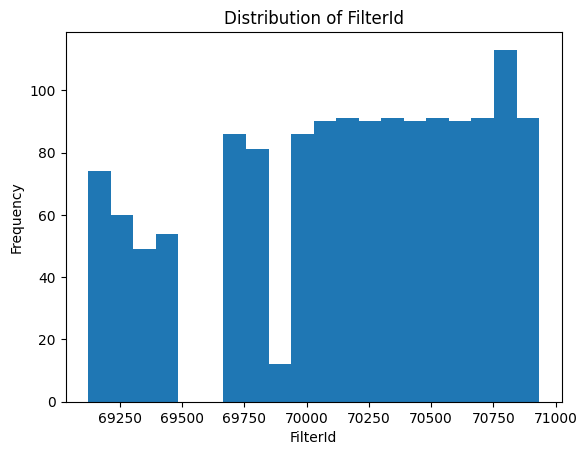


Distribution of values for column 'KeysUpdated':


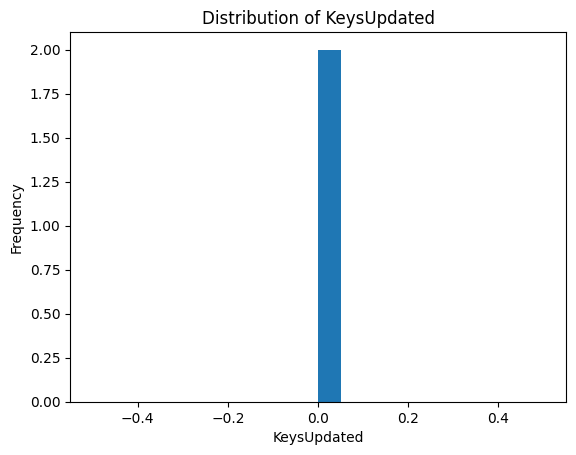


Distribution of values for column 'DirtyPages':


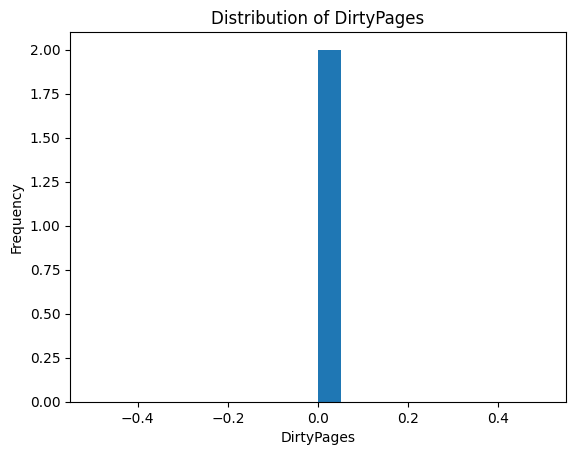


Distribution of values for column 'HiveNameLength':


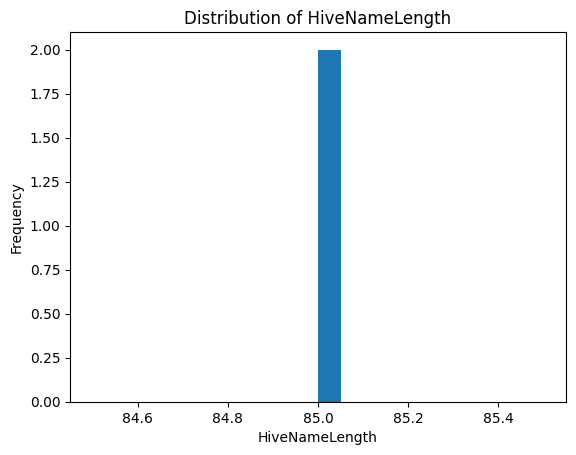


Distribution of values for column 'CountOfCredentialsReturned':


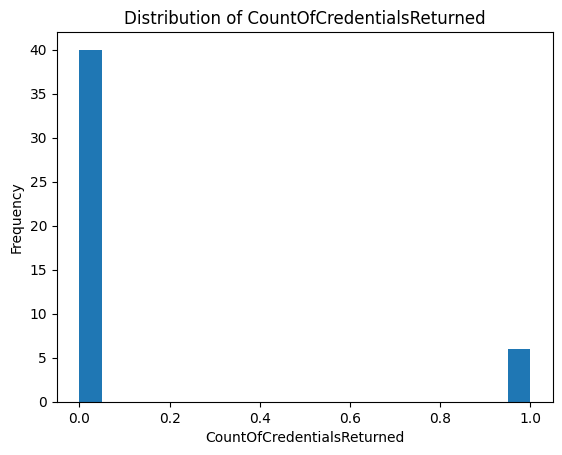


Distribution of values for column 'Type':


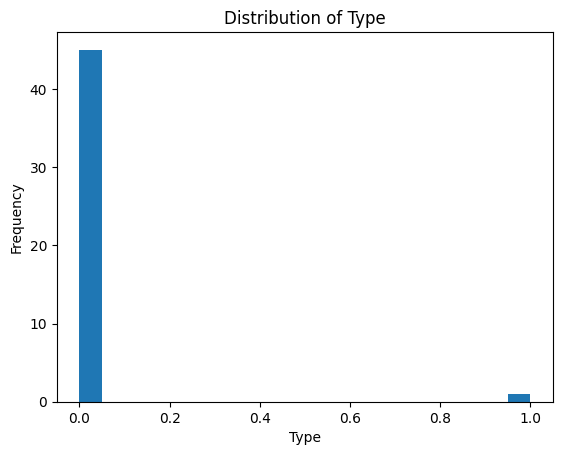


Distribution of values for column 'Port':


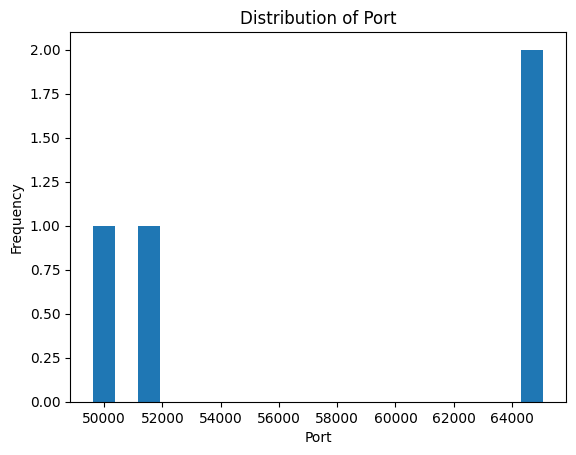


Distribution of values for column 'ReasonCode':


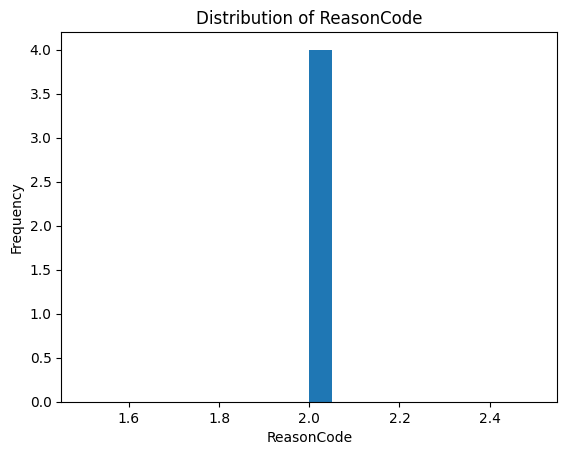


Distribution of values for column 'IPVersion':


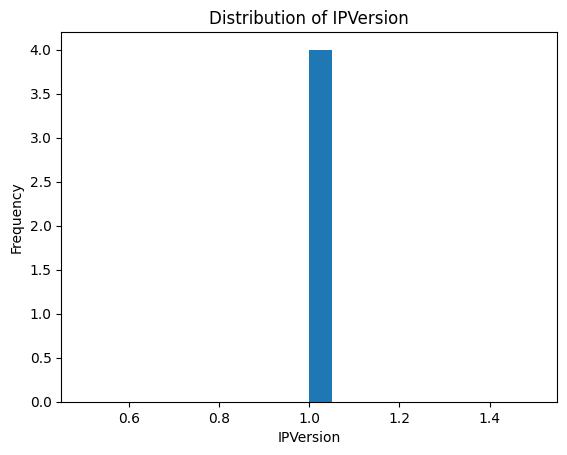


Distribution of values for column 'Level':


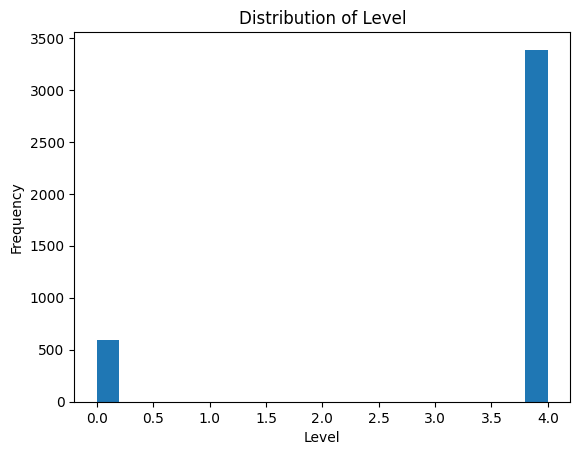


Distribution of values for column 'ProcessID':


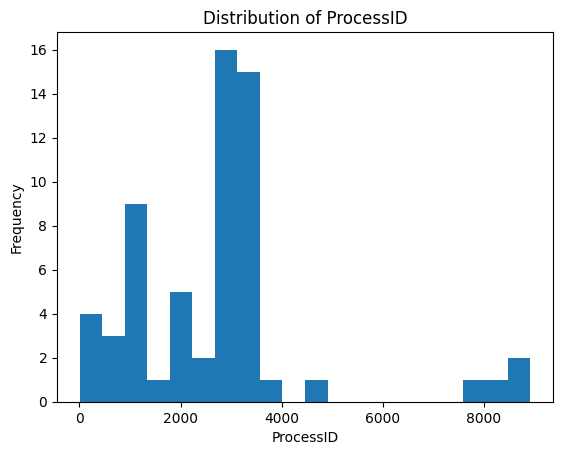


Distribution of values for column 'Session':


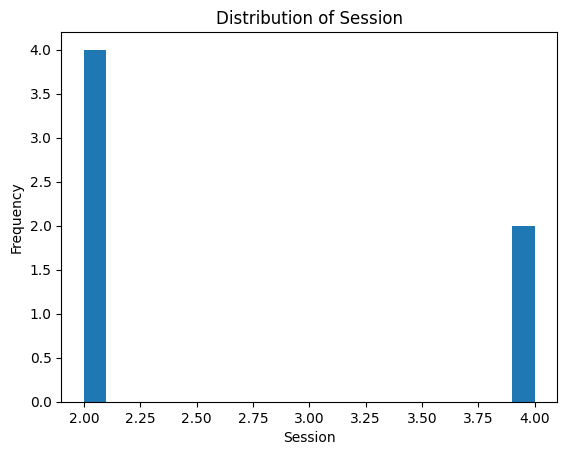


Distribution of values for column 'ClientProcessStartKey':


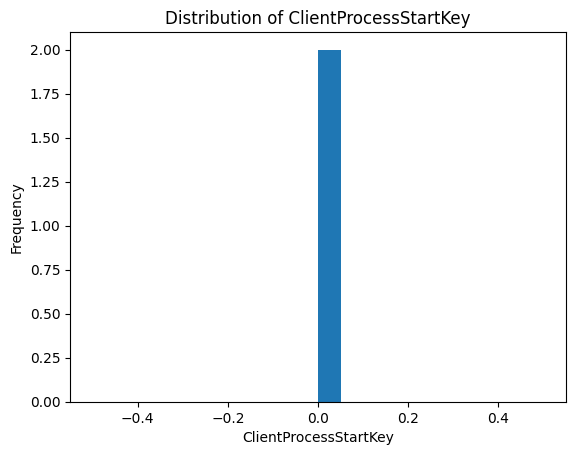


Distribution of values for column 'RpcCallClientLocality':


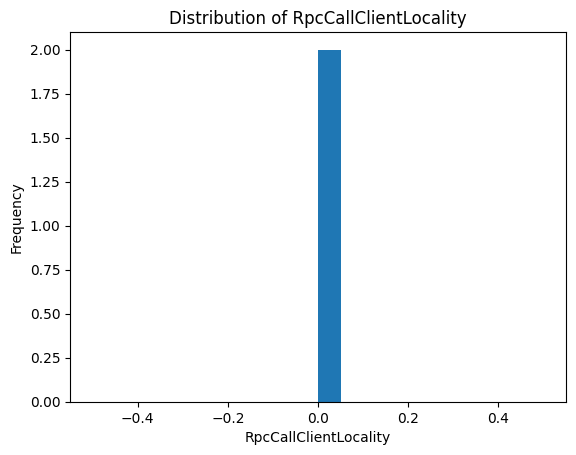


Distribution of values for column 'EnginePID':


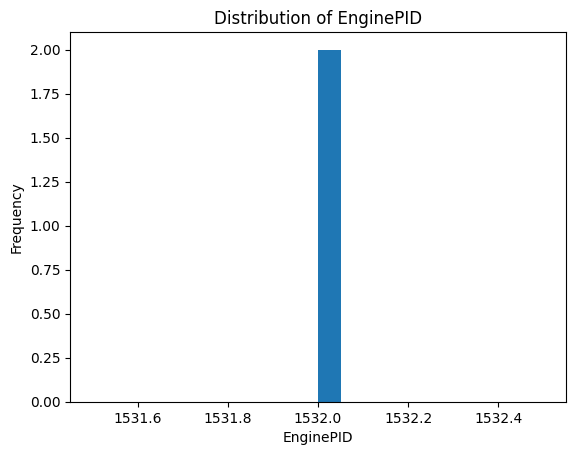


Distribution of values for column 'ResultCode':


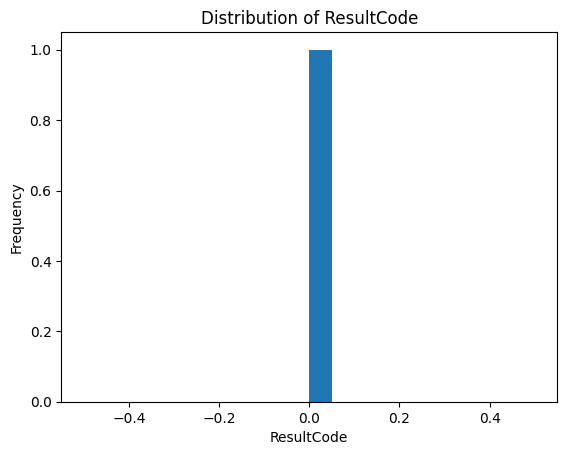


Distribution of values for column 'EventID':


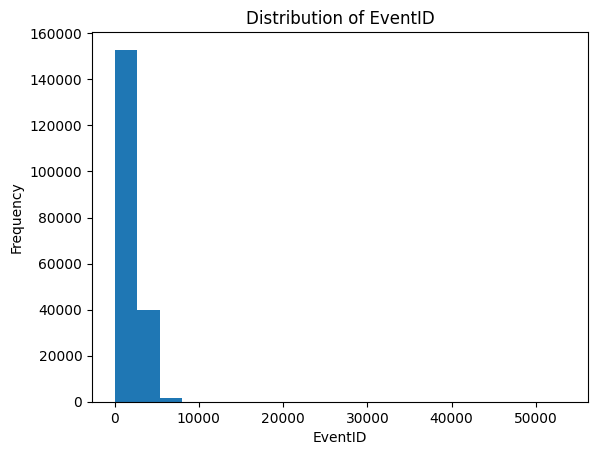


Distribution of values for column 'Task':


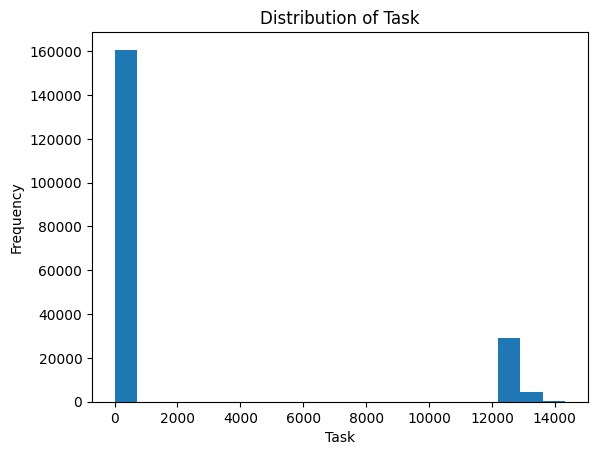

In [ ]:
# Visualizing the distribution of numeric column values in the training DataFrame by plotting gaphs
for dtype in column_types.unique():
    columns_of_type = column_types[column_types == dtype].index
    if dtype == 'float64' or dtype == 'int64':
        for column in columns_of_type:
            print(f"\nDistribution of values for column '{column}':")
            training_df[column].plot(kind='hist', bins=20)  #plotting histogram with 20 bins
            plt.title(f'Distribution of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.show()

# **Feature Engineering**



To train and test our machine learning model effectively, we couldn't just use our raw datasets as they were. We needed to transform them and create new features that would improve the model's performance and understanding.


## Features Targeting Lateral Movement Attacks

We looked into and identified many specific attacks that fall under lateral movement. When the attack is identified by the feature, it's given a 1 value, or a 0 if it is not. This helps the model detect anomalies when specific attacks are present.

###Kerbertoasting (Pass-The-Ticket Attack)

Kerberoasting is an attack method for cracking password hashes for service accounts in Active Directory. Password cracking takes place offline, helping attackers avoid detection, alerts, logging, or account lockouts. Once they log in, attackers appear as approved users and advance their attacks.

Condition:
*   Ticket Options: `0x40810000`
*   Ticket Encryption: `0x17`
*   EventID: `4769`


Source: https://adsecurity.org/?p=3458


In [ ]:
def pass_the_ticket(df, fe_df):

    # Check if columns exist in df
    if 'TicketOptions' not in df or 'EventID' not in df or 'TicketEncryptionType' not in df:
        # If either column doesn't exist, fill the new column with zeros and return
        fe_df['OneHot_pass_the_ticket'] = 0
        return fe_df

    # Apply conditions
    condition = (
        (df['TicketOptions'] == '0x40810000') &
        (df['EventID'] == 4769) &
        (df['TicketEncryptionType'] == '0x17')
    )

    # Create a new column based on the condition
    fe_df['OneHot_pass_the_ticket'] = condition.astype(int)

    return fe_df

###Pass-the-Hash Attack and Overpass-the-Hash Attack
A Pass-the-Hash attack is a technique where an attacker captures the hashed password of a user and then uses it directly to authenticate to a system, bypassing the need to know the plaintext password.

An Overpass-the-Hash attack goes a step further by manipulating the access control mechanisms (such as tokens or tickets) used for authentication, allowing the attacker to gain elevated privileges or access to resources beyond what the original user has.

These 2 types of attacks can be identified in the same way.

Condition:
*   Authentication Package Name: `'Negotiate'`
*   Logon Type: `9`
*   EventID: `4624`
*   Logon Process Name: `'seclogo'`

Source: https://blog.netwrix.com/2021/11/30/how-to-detect-pass-the-hash-attacks/


In [ ]:
def pass_the_hash(df, fe_df):

    # Check if columns exist in df
    if 'TicketOptions' not in df or 'EventID' not in df or 'TicketEncryptionType' not in df:
        # If either column doesn't exist, fill the new column with zeros and return
        fe_df['OneHot_pass_the_hash_attack'] = 0
        return fe_df

    # Apply conditions
    condition = (
        (df['AuthenticationPackageName'] == 'Negotiate') &
        (df['LogonType'] == 9) &
        (df['EventID'] == 4624) &
        (df['LogonProcessName'] == 'seclogo')
    )

    # Create a new column based on the condition
    fe_df['OneHot_pass_the_hash_attack'] = condition.astype(int)

    return fe_df

###Covenant Remote WMI Eventing ActiveScriptEventConsumers

Attackers could potentially exploit WMI ActiveScriptEventConsumers remotely to facilitate lateral movement within our network.

Condition:
*   EventID: `20`
*   Message: contains `'.*type: script.*'`
*   Channel: `'Microsoft-Windows-Sysmon/Operational'`

Source: https://threathunterplaybook.com/hunts/windows/200902-RemoteWMIActiveScriptEventConsumers/notebook.html


In [ ]:
def convenant_remote_WMI_Eventing_ActiveScriptEventConsumers(df, fe_df):

    # Check if columns exist in df
    if 'Message' not in df or 'EventID' not in df or 'Channel' not in df:
        # If either column doesn't exist, fill the new column with zeros and return
        fe_df['OneHot_convenant_remote_WMI_Eventing_ActiveScriptEventConsumers'] = 0
        return fe_df

    # Apply conditions
    condition = (
      (df['EventID'] == 20)
    & (df['Message'].str.lower().str.contains('.*type: script.*', regex=True))
    & (df['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    )

    # Create a new column based on the condition and append it to fe_df
    fe_df['OneHot_convenant_remote_WMI_Eventing_ActiveScriptEventConsumers'] = condition.astype(int)

    return fe_df

### Credential Dumping

Credential dumping is an online attack in which a malicious actor hacks into your device and steals your credentials. This typically happens from the device’s random access memory, which is RAM for short.

Condition:
*   SourceImage: `'C:\\windows\\system32\\lsass.exe'`

Source: https://www.socinvestigation.com/os-credential-dumping-lsass-memory-vs-windows-logs/

In [ ]:
def credential_dumping(df, fe_df):

    # Check if columns exist in df
    if 'SourceImage' not in df:
        # If column doesn't exist, fill the new column with zeros and return
        fe_df['OneHot_credential_dumping'] = 0
        return fe_df

    # Apply conditions
    condition = (
        (df['SourceImage'] == 'C:\\windows\\system32\\lsass.exe')
    )

    # Create a new column based on the condition
    fe_df['OneHot_credential_dumping'] = condition.astype(int)

    return fe_df

###Covenant Remote DCOM Iertutil DLL Hijacking

Threat actors may exploit a DLL hijacking vulnerability in the DCOM InternetExplorer.Application Class to remotely copy files for malicious purposes. This vulnerability allows attackers to execute unauthorized file transfers or other malicious activities by manipulating the DLL loading mechanism.

Condition:
*   Channel: `'security'`
*   EventID: `5145`
*   RelativeTargetName: ends with `'internet explorer\\iertutil.dll'`
*   AccessMask: `0x2`
*   SubjectUserName: does not end with `'$'`

Source: www.threathunterplaybook.com/hunts/windows/201009-RemoteDCOMIErtUtilDLLHijack/notebook.htm



In [ ]:
def convenant_remote_DCOM_lertutil_dll_hijacking(df, fe_df):

    # Check if columns exist in df
    if 'RelativeTargetName' not in df or 'EventID' not in df or 'Channel' not in df or 'AccessMask' not in df or 'SubjectUserName' not in df:
        # If either column doesn't exist, fill the new column with zeros and return
        fe_df['OneHot_convenant_remote_DCOM_lertutil_dll_hijacking'] = 0
        return fe_df

    # Apply conditions
    condition = (
        (df['Channel'].str.lower() == 'security')
    & (df['EventID'] == 5145)
    & (df['RelativeTargetName'].str.lower().str.endswith('internet explorer\\iertutil.dll', na=False))
    & (df['AccessMask'] == '0x2')
    & (~df['SubjectUserName'].str.endswith('$', na=False))
    )

    # Create a new column based on the condition and append it to fe_df
    fe_df['OneHot_convenant_remote_DCOM_lertutil_dll_hijacking'] = condition.astype(int)

    return fe_df

###Covenant Remote WMI Wbemcomn DLL Hijacking

In this attack, malicious actors can remotely transfer files to exploit a DLL hijacking vulnerability identified in the DCOM InternetExplorer.Application Class, potentially allowing unauthorized execution of code on the target system.

Condition:
*   Channel: `'security'`
*   EventID: `5145`
*   RelativeTargetName: ends with `'wbem\\wbemcomn.dll'`
*   AccessMask: `0x2`
*   SubjectUserName: does not end with `'$'`


Source: https://threathunterplaybook.com/hunts/windows/201009-RemoteWMIWbemcomnDLLHijack/notebook.html



In [ ]:
def convenant_remote_wmi_wbemcomn_dll_hijacking(df, fe_df):

    # Check if columns exist in df
    if 'RelativeTargetName' not in df or 'EventID' not in df or 'Channel' not in df or 'AccessMask' not in df or 'SubjectUserName' not in df:
        # If either column doesn't exist, fill the new column with zeros and return
        fe_df['OneHot_covenant_WMI_Webmcomn_DLL_Hijacking'] = 0
        return fe_df

    # Apply conditions
    condition = (
        (df['Channel'].str.lower() == 'security') &
        (df['EventID'] == 5145) &
        (df['RelativeTargetName'].str.lower().str.endswith('wbem\\wbemcomn.dll', na=False)) &
        (df['AccessMask'] == '0x2') &
        (~df['SubjectUserName'].str.endswith('$', na=False))
    )

    # Create a new column based on the condition and append it to fe_df
    fe_df['OneHot_covenant_WMI_Webmcomn_DLL_Hijacking'] = condition.astype(int)

    return fe_df

###Empire Invoke PSRemoting

Malicious actors can leverage PowerShell for various activities such as gathering information and running code. Additionally, PowerShell can facilitate remote code execution through Windows Remote Management (WinRM) services.

Condition:
*   Channel: `'security'`
*   EventID: `4688`
*   ParentProcessName or NewProcessName: ends with `'wsmprovhost.exe'`


Source: https://threathunterplaybook.com/hunts/windows/190511-RemotePwshExecution/notebook.html#

In [ ]:
def empire_envoke_PSRemoting(df, fe_df):

    # Check if columns exist in df
    if 'ParentProcessName' not in df or 'EventID' not in df or 'Channel' not in df or 'NewProcessName' not in df:
        # If either column doesn't exist, fill the new column with zeros and return
        fe_df['OneHot_empire_envoke_PSRemoting'] = 0
        return fe_df

    # Apply conditions
    condition = (
        (df['Channel'].str.lower() == 'security')
        & (df['EventID'] == 4688)
        & (
        (df['ParentProcessName'].str.lower().str.endswith('wsmprovhost.exe', na=False))
        | (df['NewProcessName'].str.lower().str.endswith('wsmprovhost.exe', na=False))
        )
    )

    # Create a new column based on the condition
    fe_df['OneHot_empire_envoke_PSRemoting'] = condition.astype(int)

    return fe_df

###Remote Scheduled Task Creation

This involves an adversary remotely creating scheduled tasks on a target system using legitimate administrative tools or protocols. By exploiting this capability, attackers can schedule malicious activities, such as running unauthorized scripts or executables, at specified times without direct access to the system.

Condition:
*   EventID: `4698`
*   AccountName != `SYSTEM`

Source: https://www.socinvestigation.com/threat-hunting-using-windows-scheduled-task/


In [ ]:
def remote_scheduled_task_creation(df, fe_df):

    # Check if columns exist in df
    if 'EventID' not in df or 'AccountName' not in df:
        # If either column doesn't exist, fill the new column with zeros and return
        fe_df['OneHot_remote_scheduled_task_creation'] = 0
        return fe_df

    # Apply conditions
    condition = (
        (df['EventID'] == 4698) &
        (df['AccountName'] != 'SYSTEM')
    )

     # Create a new column based on the condition
    fe_df['OneHot_remote_scheduled_task_creation'] = condition.astype(int)

    return fe_df


###Remote Scheduled Task Modification
This involves an adversary remotely modifying scheduled tasks on a target system using legitimate administrative tools or protocols.

Condition:
*   EventID: `4702`
*   AccountName != `SYSTEM`

Source: https://www.socinvestigation.com/threat-hunting-using-windows-scheduled-task/

In [ ]:
def remote_scheduled_task_modification(df, fe_df):

    # Check if columns exist in df
    if 'EventID' not in df or 'AccountName' not in df:
        # If either column doesn't exist, fill the new column with zeros and return
        fe_df['OneHot_remote_scheduled_task_modification'] = 0
        return fe_df

    # Apply conditions
    condition = (
        (df['EventID'] == 4702) &
        (df['AccountName'] != 'SYSTEM')
    )

    # Create a new column based on the condition
    fe_df['OneHot_remote_scheduled_task_modification'] = condition.astype(int)

    return fe_df

###Covenant Remote File Copy
This involves an adversary remotely creating or copying scheduled tasks on a target system using legitimate administrative tools or protocols.

Condition:
*   Channel: `'security'`
*   EventID: `5145`
*   AccessMask: `0x2`
*   ShareName: ends with `'\\C$'`
*   SubjectUserName: does not end with `'$'`


Source: https://threathunterplaybook.com/hunts/windows/201012-RemoteCreateFileSMB/notebook.html



In [ ]:
def covenant_remote_file_copy(df, fe_df):

    # Check if columns exist in df
    if 'EventID' not in df or 'AccountName' not in df or 'AccessMask' not in df or 'ShareName' not in df or 'SubjectUserName' not in df:
        # If either column doesn't exist, fill the new column with zeros and return
        fe_df['OneHot_covenant_remote_file_copy'] = 0
        return fe_df

    # Apply conditions
    condition = (
        (df['Channel'].str.lower() == 'security') &
        (df['EventID'] == 5145) &
        (df['AccessMask'] == '0x2') &
        (df['ShareName'].str.endswith('\\C$', na=False)) &
        (~df['SubjectUserName'].str.endswith('$', na=False))
    )

    # Create a new column based on the condition
    fe_df['OneHot_covenant_remote_file_copy'] = condition.astype(int)

    return fe_df

###Calling the Targeted Features

In [ ]:
# Function that calls all features above to create a feature engineered dataframe from a dataset
def feature_engineer_targeted(df):
  fe_df = pd.DataFrame()
  fe_df = covenant_remote_file_copy(df, fe_df)
  fe_df = convenant_remote_wmi_wbemcomn_dll_hijacking(df, fe_df)
  fe_df = convenant_remote_DCOM_lertutil_dll_hijacking(df, fe_df)
  fe_df = remote_scheduled_task_modification(df, fe_df)
  fe_df = remote_scheduled_task_creation(df, fe_df)
  fe_df = empire_envoke_PSRemoting(df, fe_df)
  fe_df = pass_the_ticket(df, fe_df)
  fe_df = convenant_remote_WMI_Eventing_ActiveScriptEventConsumers(df, fe_df)
  fe_df = pass_the_hash(df, fe_df)
  fe_df = credential_dumping(df, fe_df)
  fe_df = convenant_remote_WMI_Eventing_ActiveScriptEventConsumers(df, fe_df)
  return fe_df

## Features Targeting Anomalous Behaviours

We decided to aggregate logs in 1-minute time blocks to detect potential attacks. We did this because individual logs may not appear malicious on their own, so analyzing logs over short intervals provides a comprehensive view and helps detect potential patterns or anomalies indicative of attacks. At first we started with time blocks of 15 minutes, but quickly realized that this wasn't going to work since our datasets were not big enough. Time blocking reduces the number of data entries available within each window, and a 15-minute window left us with too few entries. We experimented with various window sizes, including 5 minutes, 10 minutes, and even 30-second intervals, but ultimately settled on 1-minute windows because they provided the optimal balance, yielding enough data points for our model to effectively utilize.

### Count Unique Features
This function counts how many unique values there are for a feature in every 1-minute block. We applied this method to features where our research indicated that a higher count of unique values within a time period could indicate suspicious activity.


In [ ]:
def count_unique_by_host(df, column_name, hostname, timestamp):
    # Make a copy of the input DataFrame to avoid modifying it in place
    df_copy = df.copy()

    # Convert 'TimeGenerated' column to datetime
    df_copy[timestamp] = pd.to_datetime(df_copy[timestamp])

    # Set timestamp column as index
    df_copy.set_index(timestamp, inplace=True)

    # Group by the host name and a 1-minute window
    grouped = df_copy.groupby([hostname, pd.Grouper(freq='1min')])

    # Calculate the number of unique values in the specified column within each 1-minute window for each host
    return grouped[column_name].transform('nunique').rename('NewColumn')

### Count Features
This function counts how many values there are for a feature in every 1-minute block. We applied this method to features where our research indicated that a higher count of values within a time period could indicate suspicious activity.


In [ ]:
def count_by_host(df, column_name, hostname, timestamp):
    # Make a copy of the input DataFrame to avoid modifying it in place
    df_copy = df.copy()

    # Convert 'TimeGenerated' column to datetime
    df_copy[timestamp] = pd.to_datetime(df_copy[timestamp])

    # Set timestamp column as index
    df_copy.set_index(timestamp, inplace=True)

     # Group by the host name and a 1-minute window
    grouped = df_copy.groupby([hostname, pd.Grouper(freq='1min')])

    # Calculate the number of unique values in the specified column within each 1-minute window for each host
    return grouped[column_name].transform('count').rename('NewColumn')

###Creating the new features with chosen columns


In [ ]:
# Function that creates a feature engineered dataset of specific features' unique counts
def feature_engineer_unique(df, training_or_testing):
  fe_df = pd.DataFrame()

  # Different features based on the dataset (our formats are different)
  if(training_or_testing == 'Training'):
    host = 'Hostname'
    time = '@timestamp'
  elif(training_or_testing == 'Testing'):
    host = 'Computer'
    time = 'TimeGenerated'
  else:
    return

  # Creating the feature engineered dataset
  fe_df['numUniqueEventIDs'] = count_unique_by_host(df, 'EventID', host, time)
  fe_df['numUniqueLogonIds'] = count_unique_by_host(df, 'LogonId', host, time)
  fe_df['numUniqueClientProcessIds'] = count_unique_by_host(df, 'ClientProcessId', host, time)
  fe_df['numUniqueProcessIds'] = count_unique_by_host(df, 'ProcessId', host, time)
  fe_df['numUniqueTargetSid'] = count_unique_by_host(df, 'TargetSid', host, time)

  return fe_df

In [ ]:
# Function that creates a feature engineered dataset of specific features' value counts
def feature_engineer_count(df, training_or_testing):
  fe_df = pd.DataFrame()

  # Different features based on the dataset (our formats are different)
  if(training_or_testing == 'Training'):
    host = 'Hostname'
    time = '@timestamp'
  elif(training_or_testing == 'Testing'):
    host = 'Computer'
    time = 'TimeGenerated'
  else:
    return

  # Creating the feature engineered dataset
  fe_df['numEventIDs'] = count_by_host(df, 'EventID', host, time)
  fe_df['numLogonIds'] = count_by_host(df, 'LogonId', host, time)
  fe_df['numClientProcessIds'] = count_by_host(df, 'ClientProcessId', host, time)
  fe_df['numProcessIds'] = count_by_host(df, 'ProcessId', host, time)
  fe_df['numTargetSid'] = count_by_host(df, 'TargetSid', host, time)
  return fe_df

In [ ]:
# Function that creates a feature engineered dataset of specific features' unique and value counts
def feature_engineer_unique_and_count(df, training_or_testing):
  fe_df = pd.DataFrame()

  # Different features based on the dataset (our formats are different)
  if(training_or_testing == 'Training'):
    host = 'Hostname'
    time = '@timestamp'
  elif(training_or_testing == 'Testing'):
    host = 'Computer'
    time = 'TimeGenerated'
  else:
    return

  # Creating the feature engineered dataset
  fe_df['numUniqueEventIDs'] = count_unique_by_host(df, 'EventID', host, time)
  fe_df['numUniqueLogonIds'] = count_unique_by_host(df, 'LogonId', host, time)
  fe_df['numUniqueClientProcessIds'] = count_unique_by_host(df, 'ClientProcessId', host, time)
  fe_df['numUniqueProcessIds'] = count_unique_by_host(df, 'ProcessId', host, time)
  fe_df['numUniqueTargetSid'] = count_unique_by_host(df, 'TargetSid', host, time)
  fe_df['numEventIDs'] = count_by_host(df, 'EventID', host, time)
  fe_df['numLogonIds'] = count_by_host(df, 'LogonId', host, time)
  fe_df['numClientProcessIds'] = count_by_host(df, 'ClientProcessId', host, time)
  fe_df['numProcessIds'] = count_by_host(df, 'ProcessId', host, time)
  fe_df['numTargetSid'] = count_by_host(df, 'TargetSid', host, time)
  return fe_df

#**Collection of the Testing Datasets**




In this section, we gathered our testing datasets. The data collection was carried out by setting up a Windows 11 environment within VirtualBox. Below, we provide a detailed explanation of how we collected both types of data.

###Helper Function

In [ ]:
# Function that merges the datasets given in an array from JSON format to a dataframe
def merge_datasets2(dataset_paths):
    merged_df = pd.DataFrame()
    for path in dataset_paths:
        with open(path, 'r') as json_file:
            data = json.load(json_file)
            new_df = pd.json_normalize(data)
            merged_df = pd.concat([merged_df, new_df], ignore_index=True)
    return merged_df

##Benign Test Data

For benign test data, we collected logs distinct from our Training Data to test our model with real-time, authentic data. So, we configured a Windows environment to gather event logs in real-time while the machine operated normally.

To extract these logs, we used the following Poweshell scripts:

**Importing the script**
```
IEX (New-Object Net.WebClient).DownloadString('https://raw.githubusercontent.com/OTRF/Security-Datasets/master/scripts/data-collectors/Export-WinEvents.ps1')
```

**Collecting Windows Event Logs**
```
@('Microsoft-Windows-Sysmon/Operational', 'Microsoft-Windows-PowerShell/Operational', 'Security', 'security', 'Windows PowerShell', 'System', 'Microsoft-Windows-WMI-Activity/Operational', 'Microsoft-Windows-TaskScheduler/Operational', 'Microsoft-Windows-Windows Firewall With Advanced Security/Firewall', 'Microsoft-Windows-TerminalServices-RemoteConnectionManager/Operational', 'Microsoft-Windows-Bits-Client/Operational') | Export-WinEvents -OutputFolder C:\ProgramData\ -Verbose
```
Next, we merged the outputted JSON files into a single data frame.

In [ ]:
# List of paths containing testing datasets for benign data
benign_datasets = ["/content/drive/MyDrive/LOGSS/WINDEV2401EVAL_Windows_MicrosoftWindowsBitsClientOperational_2024-03-19T17525452.json",
                     "/content/drive/MyDrive/LOGSS/WINDEV2401EVAL_Windows_MicrosoftWindowsPowerShellOperational_2024-03-19T17525432.json",
                     "/content/drive/MyDrive/LOGSS/WINDEV2401EVAL_Windows_MicrosoftWindowsSysmonOperational_2024-03-19T17525225.json",
                     "/content/drive/MyDrive/LOGSS/WINDEV2401EVAL_Windows_MicrosoftWindowsWMIActivityOperational_2024-03-19T17525490.json",
                     "/content/drive/MyDrive/LOGSS/WINDEV2401EVAL_Windows_MicrosoftWindowsWindows Firewall With Advanced SecurityFirewall_2024-03-19T17525518.json",
                     "/content/drive/MyDrive/LOGSS/WINDEV2401EVAL_Windows_Security_2024-03-19T17525313.json",
                     "/content/drive/MyDrive/LOGSS/WINDEV2401EVAL_Windows_System_2024-03-19T17525495.json",
                     "/content/drive/MyDrive/LOGSS/WINDEV2401EVAL_Windows_Windows PowerShell_2024-03-19T17525492.json"]

In [ ]:
# Used to combine datasets
#benign_df = merge_datasets2(benign_datasets)

#Link to CSV
url = "https://raw.githubusercontent.com/jihadjarade/winlogs/main/combined_benign.csv"
ben_testing_df = pd.read_csv(url)

##Malicious Test Data


To gather malicious test data, we opted to use Atomic Red Team on the same virtual machine.
This allowed us to run “atomic tests” on our machine that exercise the same techniques used by adversaries.
We were presented with a large library of attacks which we then sorted through and picked the ones that align with lateral movements.

The following Atomic tests were selected:
* [T1003.001 - OS Credential Dumping: LSASS Memory](https://github.com/redcanaryco/atomic-red-team/blob/master/atomics/T1003.001/T1003.001.md)
* [T1550.003 - Use Alternate Authentication Material: Pass the Ticket](https://github.com/redcanaryco/atomic-red-team/blob/master/atomics/T1550.003/T1550.003.md)
* [T1550.002 - Use Alternate Authentication Material: Pass the Hash](https://github.com/redcanaryco/atomic-red-team/blob/master/atomics/T1550.002/T1550.002.md)
* [T1546.003 - Event Triggered Execution: Windows Management Instrumentation Event Subscription](https://github.com/redcanaryco/atomic-red-team/blob/master/atomics/T1546.003/T1546.003.md)
* [T1021.003 - Remote Services: Distributed Component Object Model](https://github.com/redcanaryco/atomic-red-team/blob/master/atomics/T1021.003/T1021.003.md)
* [T1021.006 - Remote Services: Windows Remote Management](https://github.com/redcanaryco/atomic-red-team/blob/master/atomics/T1021.006/T1021.006.md)
* [T1053.005 - Scheduled Task/Job: Scheduled Task](https://github.com/redcanaryco/atomic-red-team/blob/master/atomics/T1053.005/T1053.005.md)
* [T1021.002 - Remote Services: SMB/Windows Admin Shares](https://github.com/redcanaryco/atomic-red-team/blob/master/atomics/T1021.002/T1021.002.md)
* [T1047 - Windows Management Instrumentation](https://github.com/redcanaryco/atomic-red-team/blob/master/atomics/T1047/T1047.md)
* [T1110.003 - Brute Force: Password Spraying](https://github.com/redcanaryco/atomic-red-team/blob/master/atomics/T1110.003/T1110.003.md)
* [T1558.003 - Steal or Forge Kerberos Tickets: Kerberoasting](https://github.com/redcanaryco/atomic-red-team/blob/master/atomics/T1558.003/T1558.003.md)
* [T1135 - Network Share Discovery](https://github.com/redcanaryco/atomic-red-team/blob/master/atomics/T1135/T1135.md)

After installing the AtomicRedTeam configuration framework, we were able to run Powershell scripts to execute the selected attacks.

```
Invoke-AtomicTest T1003.001
Invoke-AtomicTest T1550.003
Invoke-AtomicTest T1550.002
Invoke-AtomicTest T1546.003
Invoke-AtomicTest T1021.003
Invoke-AtomicTest T1021.006
Invoke-AtomicTest T1053.005
Invoke-AtomicTest T1021.002
Invoke-AtomicTest T1047
Invoke-AtomicTest T1110.003
Invoke-AtomicTest T1558.003
Invoke-AtomicTest T1135
```

Once the attacks were executed, we collected the logs by once again using the following Powershell script:
```
@('Microsoft-Windows-Sysmon/Operational', 'Microsoft-Windows-PowerShell/Operational', 'Security', 'security', 'Windows PowerShell', 'System', 'Microsoft-Windows-WMI-Activity/Operational', 'Microsoft-Windows-TaskScheduler/Operational', 'Microsoft-Windows-Windows Firewall With Advanced Security/Firewall', 'Microsoft-Windows-TerminalServices-RemoteConnectionManager/Operational', 'Microsoft-Windows-Bits-Client/Operational') | Export-WinEvents -OutputFolder C:\ProgramData\ -Verbose
```
Once again, we merged the outputted JSON files into one data frame.

In [ ]:
# List of paths containing testing datasets for malicious data
mal_datasets = ["/content/drive/MyDrive/RED team 2/WINDEV2401EVAL_Windows_MicrosoftWindowsBitsClientOperational_2024-03-25T13161941.json",
                    "/content/drive/MyDrive/RED team 2/WINDEV2401EVAL_Windows_MicrosoftWindowsPowerShellOperational_2024-03-25T13161857.json",
                    "/content/drive/MyDrive/RED team 2/WINDEV2401EVAL_Windows_MicrosoftWindowsSysmonOperational_2024-03-25T13161767.json",
                    "/content/drive/MyDrive/RED team 2/WINDEV2401EVAL_Windows_MicrosoftWindowsWMIActivityOperational_2024-03-25T13161945.json",
                    "/content/drive/MyDrive/RED team 2/WINDEV2401EVAL_Windows_Security_2024-03-25T13161767.json",
                    "/content/drive/MyDrive/RED team 2/WINDEV2401EVAL_Windows_System_2024-03-25T13161956.json",
                    "/content/drive/MyDrive/RED team 2/WINDEV2401EVAL_Windows_Windows PowerShell_2024-03-25T13161946.json"]

In [ ]:
# Used to combine datasets. Use
#mal_df = merge_datasets2(mal_datasets)

#Link to CSV
url = "https://raw.githubusercontent.com/jihadjarade/winlogs/main/combined_REDTEAM.csv"
mal_testing_df = pd.read_csv(url)

#**Training and Testing**

##Algorithms
Once we created all our new features and applied them to our training and testing sets, we started training and testing with different algorithms available to us through Python’s scikit-learn.


We tried these Anomaly Detection Algorithms:

*   Isolation Forest
*   Local Outlier Factor
*   One-Class SVM
*   Elliptic Envelope


### Isolation Forest

In [ ]:
def isolation_forest(training_data, test_data):

  # Remember the labels for the test data
  X_test = test_data.drop(columns=['Source'])
  y_test = test_data['Source']

  # Isolation Forest
  model = IsolationForest(contamination=0.1, random_state=42)
  model.fit(training_data)

  # Evaluate the model on the test data
  predictions = model.predict(X_test)

  # Convert predictions to binary labels
  binary_predictions = [1 if p == 1 else 0 for p in predictions]  # 1 for inliers, 0 for outliers

  # Calculate precision, recall, and F1-score on malicious data
  precision_mal = precision_score(y_test, binary_predictions, pos_label=1)
  recall_mal = recall_score(y_test, binary_predictions, pos_label=1)
  f1_mal = f1_score(y_test, binary_predictions,pos_label=1)

  # Calculate precision, recall, and F1-score overall
  precision_both = precision_score(y_test, binary_predictions, average='micro')
  recall_both = recall_score(y_test, binary_predictions, average='micro')
  f1_both = f1_score(y_test, binary_predictions, average='micro')

  return precision_mal, recall_mal, f1_mal, precision_both, recall_both, f1_both

###Local Outlier Factor

In [ ]:
def local_outlier_factor(training_data, test_data):

  # Remember the labels for the test data
  X_test = test_data.drop(columns=['Source'])
  y_test = test_data['Source']

  # Local Outlier Factor
  model = LocalOutlierFactor(n_neighbors=2, novelty=True, contamination=0.5)
  model.fit(training_data)

  # Evaluate the model on the test data
  predictions = model.predict(X_test)

  # Convert predictions to binary labels
  binary_predictions = [1 if p == 1 else 0 for p in predictions]  # 1 for inliers, 0 for outliers

  # Calculate precision, recall, and F1-score on malicious data
  precision_mal = precision_score(y_test, binary_predictions, pos_label=1)
  recall_mal = recall_score(y_test, binary_predictions, pos_label=1)
  f1_mal = f1_score(y_test, binary_predictions,pos_label=1)

  # Calculate precision, recall, and F1-score overall
  precision_both = precision_score(y_test, binary_predictions, average='micro')
  recall_both = recall_score(y_test, binary_predictions, average='micro')
  f1_both = f1_score(y_test, binary_predictions, average='micro')

  return precision_mal, recall_mal, f1_mal, precision_both, recall_both, f1_both

###One-Class SVM

In [ ]:
def one_class_svm(training_data, test_data):

  # Remember the labels for the test data
  X_test = test_data.drop(columns=['Source'])
  y_test = test_data['Source']

  # One-Class SVM
  model = OneClassSVM(gamma='auto')
  model.fit(training_data)

  # Evaluate the model on the test data
  predictions = model.predict(X_test)

  # Convert predictions to binary labels
  binary_predictions = [1 if p == 1 else 0 for p in predictions]  # 1 for inliers, 0 for outliers

  # Calculate precision, recall, and F1-score on malicious data
  precision_mal = precision_score(y_test, binary_predictions, pos_label=1)
  recall_mal = recall_score(y_test, binary_predictions, pos_label=1)
  f1_mal = f1_score(y_test, binary_predictions,pos_label=1)

  # Calculate precision, recall, and F1-score overall
  precision_both = precision_score(y_test, binary_predictions, average='micro')
  recall_both = recall_score(y_test, binary_predictions, average='micro')
  f1_both = f1_score(y_test, binary_predictions, average='micro')

  return precision_mal, recall_mal, f1_mal, precision_both, recall_both, f1_both

###Elliptic Envelope

In [ ]:
def elliptic_envelope(training_data, test_data):

  # Remember the labels for the test data
  X_test = test_data.drop(columns=['Source'])
  y_test = test_data['Source']

  # Elliptic Envelope
  model = EllipticEnvelope(random_state=0)
  model.fit(training_data)

  # Evaluate the model on the test data
  predictions = model.predict(X_test)

  # Convert predictions to binary labels
  binary_predictions = [1 if p == 1 else 0 for p in predictions]  # 1 for inliers, 0 for outliers

  # Calculate precision, recall, and F1-score on malicious data
  precision_mal = precision_score(y_test, binary_predictions, pos_label=1)
  recall_mal = recall_score(y_test, binary_predictions, pos_label=1)
  f1_mal = f1_score(y_test, binary_predictions,pos_label=1)

  # Calculate precision, recall, and F1-score overall
  precision_both = precision_score(y_test, binary_predictions, average='micro')
  recall_both = recall_score(y_test, binary_predictions, average='micro')
  f1_both = f1_score(y_test, binary_predictions, average='micro')

  return precision_mal, recall_mal, f1_mal, precision_both, recall_both, f1_both


##Helper Functions

###Removing Duplicates

Since we grouped by 1-minute blocks, we had many duplicate rows. We did not want our model to learn from a row more than once and give it higher importance, so we tried removing duplicates from the feature engineered dataset.

We tested our different algorithms with removing duplicates and without. We quickly saw that removing duplicates improved our score by a lot, so we decided to remove duplicates for all other algorithm variations we tried.

In [ ]:
def remove_duplicates(dataframe):

  cleaned_df = dataframe.drop_duplicates()

  return cleaned_df

###Normalizing

To improve results, we also experimented with normalizing our data. We also quickly learned that this was not improving our results so we stopped using it.

In [ ]:
def normalize(dataframe):

  # Copy the original dataframe to avoid modifying the original data
  normalized_df = dataframe.copy()

  # Iterate over each column in the dataframe
  for column in normalized_df.columns:
      # Confirm that column contains numerical data
      if normalized_df[column].dtype in ['int64', 'float64']:
          # Calculate min and max values of the column
          min_value = normalized_df[column].min()
          max_value = normalized_df[column].max()
          # Apply min-max normalization to the column
          normalized_df[column] = (normalized_df[column] - min_value) / (max_value - min_value)

  return normalized_df

###Labeling Test Data

When testing, we needed to label the test data as malicious or benign. We went with 0 for benign (outliers), and 1 for malicious (inlier).

In [ ]:
def label_test_data(test_data, value):

  # Copy the original dataframe to avoid modifying the original data
  labeled_data = test_data.copy()

  labeled_data['Source'] = value # 0 for outliers (benign) or 1 for inliers (malicious)

  return labeled_data

###Calling the Algorithms

In [ ]:
# Function to train and test the data. It removes duplicates and labels the test data.
def train_and_test(fe_df, fe_ben_df, fe_mal_df, algorithm):

  # Create copy for all given dataframes
  df_training = fe_df.copy()
  test_ben = fe_ben_df.copy()
  test_mal = fe_mal_df.copy()

  # Remove the duplicates
  df_training = remove_duplicates(df_training)
  test_ben = remove_duplicates(test_ben)
  test_mal = remove_duplicates(test_mal)

  # Label the test data
  test_ben = label_test_data(test_ben, 0)
  test_mal = label_test_data(test_mal, 1)

  # Combine the test datasets together (malicious and benign)
  df_test = pd.concat([test_ben, test_mal], ignore_index=True)
  warnings.filterwarnings('ignore')

  # Call the algorithm based on the given parameter
  if(algorithm == 'Isolation'):
    precision_mal, recall_mal, f1_mal, precision_both, recall_both, f1_both = isolation_forest(df_training, df_test)
    print("Isolation Forest")

  elif (algorithm == 'LocalOutlier'):
    precision_mal, recall_mal, f1_mal, precision_both, recall_both, f1_both = local_outlier_factor(df_training, df_test)
    print("Local Outlier Factor")

  elif (algorithm == 'OneClassSVM'):
    precision_mal, recall_mal, f1_mal, precision_both, recall_both, f1_both = one_class_svm(df_training, df_test)
    print("One-Class SVM")

  elif (algorithm == 'Elliptic'):
    precision_mal, recall_mal, f1_mal, precision_both, recall_both, f1_both = elliptic_envelope(df_training, df_test)
    print("Elliptic Envelope")

  else:
    print("Algorithm not found")

  # Print the metrics for malicious data and micro-average
  print("Metrics Table - on malicious data:")
  print(f"Precision: {precision_mal:.2f}")
  print(f"Recall: {recall_mal:.2f}")
  print(f"F1-score: {f1_mal:.2f}")
  print("Metrics Table: - micro average:")
  print(f"Precision: {precision_both:.2f}")
  print(f"Recall: {recall_both:.2f}")
  print(f"F1-score: {f1_both:.2f}")

##Training and Testing Experiments

We tried many experiements and variations of different algorithms while combining features. In this section, a few of them and their results are shown.

###Experiment 1 - Features Targeting Lateral Movement Attacks
In this experiment, we are testing our targeted features.

This experiment was unsuccessful because the format and features of our testing data differed significantly from our training data. Many of the features we had initially planned to use were absent in the test set, forcing us to disregard most of them. Additionally, for the features that were available, the test data did not contain any values that our functions could label as malicious.

###Experiment 2 - Unique Count
For this experiment, we are testing all 4 algorithms with our 'unique count' features.

In [ ]:
fe_df = feature_engineer_unique(training_df, 'Training')
fe_mal_df = feature_engineer_unique(mal_testing_df, 'Testing')
fe_ben_df = feature_engineer_unique(ben_testing_df, 'Testing')

####Isolation Forest

In [ ]:
train_and_test(fe_df, fe_mal_df, fe_ben_df, 'Isolation')

Isolation Forest
Metrics Table - on malicious data:
Precision: 0.62
Recall: 0.52
F1-score: 0.57
Metrics Table: - micro average:
Precision: 0.44
Recall: 0.44
F1-score: 0.44


####Local Outlier Factor

In [ ]:
train_and_test(fe_df, fe_mal_df, fe_ben_df, 'LocalOutlier')

Local Outlier Factor
Metrics Table - on malicious data:
Precision: 0.55
Recall: 0.07
F1-score: 0.12
Metrics Table: - micro average:
Precision: 0.30
Recall: 0.30
F1-score: 0.30


####One-Class SVM

In [ ]:
train_and_test(fe_df, fe_mal_df, fe_ben_df, 'OneClassSVM')

One-Class SVM
Metrics Table - on malicious data:
Precision: 0.40
Recall: 0.02
F1-score: 0.04
Metrics Table: - micro average:
Precision: 0.29
Recall: 0.29
F1-score: 0.29


####Elliptic Envelope

In [ ]:
train_and_test(fe_df, fe_mal_df, fe_ben_df, 'Elliptic')

Elliptic Envelope
Metrics Table - on malicious data:
Precision: 0.61
Recall: 0.36
F1-score: 0.45
Metrics Table: - micro average:
Precision: 0.39
Recall: 0.39
F1-score: 0.39


####**Results**
For this experiment, Isolation Forest yielded the best results with a precision on the malicious test data of 62%. Elliptic Envelope also gave a precision of 61% on the malicious test data but gave a lower micro-average overall when compared to Isolation Forest.

###Experiment 3 - Value Counts
For this experiment, we are testing all 4 algorithms with our 'value count' features.

In [ ]:
fe_df = feature_engineer_count(training_df, 'Training')
fe_mal_df = feature_engineer_count(mal_testing_df, 'Testing')
fe_ben_df = feature_engineer_count(ben_testing_df, 'Testing')

####Isolation Forest

In [ ]:
train_and_test(fe_df, fe_mal_df, fe_ben_df, 'Isolation')

Isolation Forest
Metrics Table - on malicious data:
Precision: 0.63
Recall: 0.67
F1-score: 0.65
Metrics Table: - micro average:
Precision: 0.51
Recall: 0.51
F1-score: 0.51


####Local Outlier Factor

In [ ]:
train_and_test(fe_df, fe_mal_df, fe_ben_df, 'LocalOutlier')

Local Outlier Factor
Metrics Table - on malicious data:
Precision: 0.55
Recall: 0.18
F1-score: 0.27
Metrics Table: - micro average:
Precision: 0.34
Recall: 0.34
F1-score: 0.34


####One-Class SVM

In [ ]:
train_and_test(fe_df, fe_mal_df, fe_ben_df, 'OneClassSVM')

One-Class SVM
Metrics Table - on malicious data:
Precision: 0.50
Recall: 0.03
F1-score: 0.06
Metrics Table: - micro average:
Precision: 0.32
Recall: 0.32
F1-score: 0.32


####Elliptic Envelope

In [ ]:
train_and_test(fe_df, fe_mal_df, fe_ben_df, 'Elliptic')

Elliptic Envelope
Metrics Table - on malicious data:
Precision: 0.67
Recall: 0.96
F1-score: 0.79
Metrics Table: - micro average:
Precision: 0.65
Recall: 0.65
F1-score: 0.65


####**Results**
For this experiment, Elliptic Envelope yielded the best results by far. We got a precion of 67%, recall of 96% and an f1-score of 79% on malicious data. The overall micro-average it gave us was 65%. Isolation Forest also gave decent results with an f1-score of 65% on malicious data.

###Experiment 4 - Unique and Value Count

For this experiment, we are testing our 'unique count' features and our 'value count' features together.

In [ ]:
fe_df = feature_engineer_unique_and_count(training_df, 'Training')
fe_mal_df = feature_engineer_unique_and_count(mal_testing_df, 'Testing')
fe_ben_df = feature_engineer_unique_and_count(ben_testing_df, 'Testing')

####Isolation Forest

In [ ]:
train_and_test(fe_df, fe_mal_df, fe_ben_df, 'Isolation')

Isolation Forest
Metrics Table - on malicious data:
Precision: 0.66
Recall: 0.67
F1-score: 0.67
Metrics Table: - micro average:
Precision: 0.53
Recall: 0.53
F1-score: 0.53


####Local Outlier Factor

In [ ]:
train_and_test(fe_df, fe_mal_df, fe_ben_df, 'LocalOutlier')

Local Outlier Factor
Metrics Table - on malicious data:
Precision: 0.50
Recall: 0.08
F1-score: 0.14
Metrics Table: - micro average:
Precision: 0.30
Recall: 0.30
F1-score: 0.30


####One-Class SVM

In [ ]:
train_and_test(fe_df, fe_mal_df, fe_ben_df, 'OneClassSVM')

One-Class SVM
Metrics Table - on malicious data:
Precision: 0.00
Recall: 0.00
F1-score: 0.00
Metrics Table: - micro average:
Precision: 0.28
Recall: 0.28
F1-score: 0.28


####Elliptic Envelope

In [ ]:
train_and_test(fe_df, fe_mal_df, fe_ben_df, 'Elliptic')

Elliptic Envelope
Metrics Table - on malicious data:
Precision: 0.70
Recall: 0.80
F1-score: 0.74
Metrics Table: - micro average:
Precision: 0.61
Recall: 0.61
F1-score: 0.61


####**Results**
For this experiment, Elliptic Envelope also out performed the others with a precision of 70%, a recall of 80% and and f1-score of 74% on malicious data. The overall micro-average it gave was 61%. Isolation Forest also performed well with an f1-score of 67% on malicious data.



##Discussion

After reviewing our four experiments, we can conclude that the combined use of 'unique count' and 'value count' improved our results. The Elliptic Envelope algorithm performed the best, while the One-Class SVM consistently delivered the weakest results. Both the Isolation Forest and the Local Outlier Factor showed potential, though they still have significant room for improvement. Moving forward, we could further explore the Elliptic Envelope by tweaking some parameters and testing it with various features. Additionally, adjusting parameters for the Isolation Forest and Local Outlier Factor could potentially enhance their performance, as they did show promise in some scenarios.

#**Conclusion**


Overall, this project has been highly educational, providing us with a better understanding of how a Windows system handles logs and the concept of lateral movement. We also had the opportunity to further enhance our understanding of machine learning concepts and familiarised ourselves with new algorithms during our training and testing phase. Additionally, the project presented significant challenges that were also educational. At each stage, we encountered new obstacles that required us to find optimal solutions. Due to time constraints, compromises were necessary to ensure functionality.

We recognize the areas for improvement that would lead us to achieve a higher detection score. To enhance our work, we would collect logs from a Windows 10 environment instead of Windows 11. This change would allow us to conduct more targeted atomic tests, resulting in a richer set of malicious logs to test on. Our ability to run atomic tests was limited in Windows 11, which affected the variety of logs we could gather. Furthermore, the format of the logs we collected differed from those of the training dataset, which led to many of the features we expected to see to be missing in the testing dataset. This could be due to the source of our training dataset configuring logs differently without disclosure or due to the logs originating from a Windows 10 computer with differing log formats.

With additional time, we would explore a broader range of algorithms and fine-tune parameters for better performance. Currently, we have utilised Isolation Forest, Local Outlier Factor, One-Class SVM and Elliptic Envelope but more algorithms would be explored given the opportunity. Moreover, as with any machine learning project, there is always room for improvement in feature engineering. To enhance our features further, we would create new ones and test our model to raise our detection rate.


#**References**

Jeyashankar, Anusthika. “Threat Hunting Using Windows Scheduled Task.” *Security Investigation*, 19 Dec. 2021, www.socinvestigation.com/threat-hunting-using-windows-scheduled-task.

Jeyashankar, Anusthika. “OS Credential Dumping- LSASS Memory vs Windows Logs.” *Security Investigation*, 8 Sept. 2022, www.socinvestigation.com/os-credential-dumping-lsass-memory-vs-windows-logs/.

Metcalf, Sean. “Detecting Kerberoasting Activity.” *Active Directory Security*, 8 Feb. 2017, www.adsecurity.org/?p=3458.

Red Canary. Atomic Red Team. *GitHub*, 2023, https://github.com/redcanaryco/atomic-red-team.

Rodriguez, Roberto, and Jose Luis Rodriguez. *Security Datasets*, 2022, www.securitydatasets.com/introduction.html.

Rodriguez, Roberto, and Jose Luis Rodriguez. *Threat Hunter Playbook*, 2022, www.threathunterplaybook.com/intro.html.

“Sklearn.Svm.Oneclasssvm.” *Scikit*, www.scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html.

“Sklearn.ensemble.IsolationForest.” *Scikit*, www.scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html.

“Sklearn.covariance.EllipticEnvelope.” *Scikit*, www.scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html.

“Sklearn.neighbors.LocalOutlierFactor.” *Scikit*, www.scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html.

Warren, Jeff. “How to Detect Pass-the-Hash Attacks.” *Netwrix Blog*, www.blog.netwrix.com/2021/11/30/how-to-detect-pass-the-hash-attacks/.

#**Team Contribution for the Report**

|                         | Dalia | Jihad |
|-------------------------|-------|-------|
| Collection of the Training Dataset | 100% | 100% |
| Profiling               | 100%  | 100%  |
| Feature Engineering     | 100%  | 100%  |
| Collection of the Testing Datasets | 100% | 100% |
| Training and Testing    | 100%  | 100%  |
